In [1]:
import numpy as np
import sys
import os
import re
import cv2
import trimesh
import tetgen 
import time
import gmsh
import meshio 

import matplotlib.pyplot as plt
import SimpleITK as sitk
import pymeshfix as pfix
import pyvista as pv
import skimage.morphology as skm
import iso2mesh as i2m
import pygalmesh as pygm
import pymeshlab as ml

from iso2mesh import plotmesh
from skimage import io
from scipy import ndimage as ndi
from skimage.filters import threshold_otsu
from tqdm.notebook import tqdm
from skimage.transform import resize
from typing import Any, Dict, Optional, Tuple, List

sys.path.append('./src')  # to import alveoRVE from parent directory

from alveoRVE.plot.mpl import show_four_panel_volume
from alveoRVE.plot.pv import view_surface

%load_ext autoreload
%autoreload 2

In [2]:
def matlab_to_python_conv(no, fc): 
    no_out = no[:, :3].copy()
    fc_out = (np.atleast_2d(fc).astype(np.int64)[:, :3] - 1).astype(np.int32)
    return no_out, fc_out

In [3]:
mesh = meshio.read('./output_after_dedup.stl')
nodes = mesh.points
cells_dict = mesh.cells_dict
print(f"cells_dict: {cells_dict}")
elems = mesh.cells_dict['triangle']
print(nodes.shape)
print(elems.shape)

/home/bnherrerac/miniconda3/envs/fenicsx-env/lib/python3.11/site-packages/meshio/stl/_stl.py:40: RuntimeWarning: overflow encountered in scalar multiply
  if 84 + num_triangles * 50 == filesize_bytes:


cells_dict: {'triangle': array([[    0,     1,     2],
       [    0,     1,     3],
       [    0,     2,     4],
       ...,
       [20933, 20940, 20941],
       [20938, 20939, 20941],
       [20940, 20939, 20941]], shape=(42148, 3))}
(20942, 3)
(42148, 3)


In [4]:
view_surface(nodes, elems)

Widget(value='<iframe src="http://localhost:42663/index.html?ui=P_0x7f5bd0b56e10_0&reconnect=auto" class="pyvi…

In [5]:
# Mesh cleaning (removes degeneracies, self-intersections and isolated nodes)
clean_nodes, clean_elems = pfix.clean_from_arrays(nodes, elems)
print(f"cleaned\nold shapes: nodes {nodes.shape}, elems {elems.shape}\nnew shapes: clean_nodes {clean_nodes.shape}, clean_elems {clean_elems.shape}")
# Checks whether original mesh was already clean
print(np.array_equal(nodes, clean_nodes))
print(np.array_equal(elems, clean_elems))
view_surface(clean_nodes, clean_elems, title="after dedup and pfix cleaning")

cleaned
old shapes: nodes (20942, 3), elems (42148, 3)
new shapes: clean_nodes (20659, 3), clean_elems (41446, 3)
False
False


Widget(value='<iframe src="http://localhost:42663/index.html?ui=P_0x7f5bce4ade90_1&reconnect=auto" class="pyvi…

In [6]:
clean_nodes_resampled, clean_elems_resampled = i2m.meshresample(clean_nodes, clean_elems+1, 0.8)
# view_surface(*matlab_to_python_conv(clean_nodes_resampled, clean_elems_resampled), title="v2m unique faces")

= Surface Mesh Simplification Utility (Based on CGAL 3.4) =
(modified for iso2mesh by Qianqian Fang)
http://iso2mesh.sf.net

max face ratio=0.800000
edge index number 124338
mesh simplificaton in progress ...

Edges collected: 62169
Edges proccessed: 4211
Edges collapsed: 4145

Edges not collapsed due to topological constrians: 65
Edge not collapsed due to cost computation constrians: 0
Edge not collapsed due to placement computation constrians: 0

Finished...
12435 edges removed.
49734 final edges.


In [7]:
mesh = trimesh.Trimesh(vertices=clean_nodes_resampled,
      faces = clean_elems_resampled - 1)
print(mesh.is_watertight)
print(mesh.is_winding_consistent)
print(mesh.vertices.shape, mesh.faces.shape)
print(mesh.bounds)
view_surface(mesh.vertices, mesh.faces, title="original")
# smoothed_mesh = trimesh.smoothing.filter_humphrey(mesh, alpha=0.5, beta=0.5, iterations=10)
smoothed_mesh = trimesh.smoothing.filter_mut_dif_laplacian(mesh, lamb=0.5, iterations=10)
print(smoothed_mesh.is_watertight)
view_surface(smoothed_mesh.vertices, smoothed_mesh.faces, title="smoothed")

True
True
(16514, 3) (33156, 3)
[[  0.451768   1.2204     1.94187 ]
 [119.549    118.048    118.048   ]]


Widget(value='<iframe src="http://localhost:42663/index.html?ui=P_0x7f5d0460e750_2&reconnect=auto" class="pyvi…

True


Widget(value='<iframe src="http://localhost:42663/index.html?ui=P_0x7f5bb03a8790_3&reconnect=auto" class="pyvi…

In [8]:
# normalize nodes 
normalized_nodes = (smoothed_mesh.vertices - smoothed_mesh.vertices.min(axis=0)) /  (smoothed_mesh.vertices.max(axis=0) - smoothed_mesh.vertices.min(axis=0))

normalized_mesh = trimesh.Trimesh(vertices=normalized_nodes, faces=clean_elems_resampled - 1)

view_surface(normalized_mesh.vertices, normalized_mesh.faces, title="normalized")

Widget(value='<iframe src="http://localhost:42663/index.html?ui=P_0x7f5bb042ea50_4&reconnect=auto" class="pyvi…

### Tetrahedralization of non-flattened mesh

In [9]:
# TetGen tetrahedralization
tetra_mesh = tetgen.TetGen(normalized_mesh.vertices, normalized_mesh.faces)
tnodes, telems = tetra_mesh.tetrahedralize(order=1, minratio=1.4, quality=True)

In [10]:
print(f"tnodes shape: {tnodes.shape}, telems shape: {telems.shape}")

tnodes shape: (21406, 3), telems shape: (75815, 4)


In [11]:
grid = tetra_mesh.grid
grid.plot(show_edges=True)

Widget(value='<iframe src="http://localhost:42663/index.html?ui=P_0x7f5ba013df90_5&reconnect=auto" class="pyvi…

In [12]:
cells = grid.cells.reshape(-1, 5)[:, 1:]
cell_center = grid.points[cells].mean(1)

mask = cell_center[:, 1] < 0.5
cell_ind = mask.nonzero()[0]
subgrid = grid.extract_cells(cell_ind)

# advanced plotting
plotter = pv.Plotter()
plotter.add_mesh(subgrid, 'lightgrey', lighting=True, show_edges=True)
plotter.add_mesh(tetra_mesh.mesh, 'red', 'wireframe', opacity=0.2) # style = 'wireframe'
plotter.add_legend([[' Input Mesh ', 'r'],
                    [' tetrahedralize mesh ', 'black']])
plotter.show()

Widget(value='<iframe src="http://localhost:42663/index.html?ui=P_0x7f5ba0148310_6&reconnect=auto" class="pyvi…

### Flattening

In [13]:
# normalized_mesh = trimesh.Trimesh(vertices=normalized_nodes, faces=clean_elems_resampled - 1)

d = 0.01

x_plane_min_normal = (1,0,0)
x_plane_min_point = (d,0,0)
x_plane_max_normal = (-1,0,0)
x_plane_max_point = (1-d,0,0)

y_plane_min_normal = (0,1,0)
y_plane_min_point = (0,d,0)
y_plane_max_normal = (0,-1,0)
y_plane_max_point = (0,1-d,0)   

z_plane_min_normal = (0,0,1)
z_plane_min_point = (0,0,d)
z_plane_max_normal = (0,0,-1)
z_plane_max_point = (0,0,1-d)

# consecutive slicing and capping
normalized_mesh_sliced_x_min = normalized_mesh.slice_plane(x_plane_min_point, x_plane_min_normal, cap=True)
print(f"new vertices after x min slice: {normalized_mesh_sliced_x_min.vertices.shape}")
normalized_mesh_sliced_x_max = normalized_mesh_sliced_x_min.slice_plane(x_plane_max_point, x_plane_max_normal, cap=True)
print(f"new vertices after x max slice: {normalized_mesh_sliced_x_max.vertices.shape}")
normalized_mesh_sliced_y_min = normalized_mesh_sliced_x_max.slice_plane(y_plane_min_point, y_plane_min_normal, cap=True)
print(f"new vertices after y min slice: {normalized_mesh_sliced_y_min.vertices.shape}")
normalized_mesh_sliced_y_max = normalized_mesh_sliced_y_min.slice_plane(y_plane_max_point, y_plane_max_normal, cap=True)
print(f"new vertices after y max slice: {normalized_mesh_sliced_y_max.vertices.shape}")
normalized_mesh_sliced_z_min = normalized_mesh_sliced_y_max.slice_plane(z_plane_min_point, z_plane_min_normal, cap=True)
print(f"new vertices after z min slice: {normalized_mesh_sliced_z_min.vertices.shape}")
normalized_mesh_sliced_all = normalized_mesh_sliced_z_min.slice_plane(z_plane_max_point, z_plane_max_normal, cap=True)
print(f"new vertices after z max slice: {normalized_mesh_sliced_all.vertices.shape}")

view_surface(normalized_mesh_sliced_all.vertices, normalized_mesh_sliced_all.faces, title="normalized")

new vertices after x min slice: (16464, 3)
new vertices after x max slice: (16332, 3)
new vertices after y min slice: (16338, 3)
new vertices after y max slice: (16276, 3)
new vertices after z min slice: (16285, 3)
new vertices after z max slice: (16215, 3)


Widget(value='<iframe src="http://localhost:42663/index.html?ui=P_0x7f5b842244d0_7&reconnect=auto" class="pyvi…

In [14]:
capped_verts, capped_faces = normalized_mesh_sliced_all.vertices, normalized_mesh_sliced_all.faces

In [15]:
# # ============================================================
# # Remesh planar caps (from trimesh.slice_plane(..., cap=True))
# # using Gmsh 2D constrained triangulation, then replace in mesh
# # ============================================================
# import numpy as np
# import trimesh
# import gmsh
# def _remesh_single_plane(mesh: trimesh.Trimesh,
#                          axis: str,
#                          value: float,
#                          h_cap: float,
#                          tol: float = 1e-8,
#                          mirror_to: float | None = None) -> trimesh.Trimesh:
#     """
#     Replace planar patch(es) on {axis} = value with a Gmsh 2D CDT (outer + holes),
#     reusing the ORIGINAL boundary vertices so seams are conforming.
#     Optionally mirror the same triangulation to {axis} = mirror_to; faces on the
#     opposite plane are removed before cloning to avoid multiplicity.
#     """
#     # ---- helpers ----
#     def order_edge_loops(edges: np.ndarray) -> list[list[int]]:
#         adj: dict[int, list[int]] = {}
#         for a, b in edges.astype(int, copy=False):
#             a = int(a); b = int(b)
#             adj.setdefault(a, []).append(b)
#             adj.setdefault(b, []).append(a)
#         used: set[tuple[int,int]] = set()
#         loops: list[list[int]] = []
#         for start in list(adj.keys()):
#             inc = [nb for nb in adj[start] if (min(start, nb), max(start, nb)) not in used]
#             if not inc:  # nothing unused incident
#                 continue
#             prev = None; curr = start; loop = [curr]
#             while True:
#                 nxt = None
#                 for nb in adj.get(curr, []):
#                     e = (min(curr, nb), max(curr, nb))
#                     if e in used: 
#                         continue
#                     if prev is None or nb != prev:
#                         nxt = nb; used.add(e); break
#                 if nxt is None: break
#                 prev, curr = curr, nxt
#                 loop.append(curr)
#                 if curr == start: break
#             if len(loop) >= 3 and loop[0] == loop[-1]:
#                 loops.append(loop)
#         return loops

#     def poly_area_2d(UV: np.ndarray) -> float:
#         x, y = UV[:, 0], UV[:, 1]
#         return 0.5 * np.sum(x[:-1]*y[1:] - x[1:]*y[:-1])

#     def gmsh_init_safe():
#         try:
#             if not gmsh.isInitialized():
#                 gmsh.initialize()
#         except AttributeError:
#             try: gmsh.initialize()
#             except Exception: pass

#     def gmsh_finish_safe():
#         try:
#             if gmsh.isInitialized():
#                 gmsh.finalize()
#         except AttributeError:
#             try: gmsh.finalize()
#             except Exception: pass

#     # ---- select plane faces and coordinate transforms ----
#     V, F = mesh.vertices, mesh.faces
#     if axis == 'x':
#         ax = 0
#         to2D = lambda P: np.c_[P[:,1], P[:,2]]
#         from2D = lambda UV, c: np.c_[np.full((len(UV),), c), UV[:,0], UV[:,1]]
#         shift_vec = lambda a,b: np.array([b-a, 0, 0], float)
#     elif axis == 'y':
#         ax = 1
#         to2D = lambda P: np.c_[P[:,0], P[:,2]]
#         from2D = lambda UV, c: np.c_[UV[:,0], np.full((len(UV),), c), UV[:,1]]
#         shift_vec = lambda a,b: np.array([0, b-a, 0], float)
#     else:
#         ax = 2
#         to2D = lambda P: np.c_[P[:,0], P[:,1]]
#         from2D = lambda UV, c: np.c_[UV[:,0], UV[:,1], np.full((len(UV),), c)]
#         shift_vec = lambda a,b: np.array([0, 0, b-a], float)

#     on_plane = np.isclose(V[:, ax], float(value), atol=tol)
#     mask_face = on_plane[F].all(axis=1)
#     cap_faces_idx = np.nonzero(mask_face)[0]
#     if len(cap_faces_idx) == 0:
#         print(f"[cap] no faces detected on {axis}={value}")
#         return mesh
#     print(f"[cap] {axis}={value}: faces={len(cap_faces_idx)}")

#     # components on the plane
#     FA = mesh.face_adjacency
#     keep = mask_face[FA].all(axis=1)
#     import networkx as nx
#     G = nx.Graph()
#     G.add_nodes_from([int(i) for i in cap_faces_idx.tolist()])
#     for a, b in FA[keep]:
#         G.add_edge(int(a), int(b))
#     comps = [np.sort(np.fromiter((int(x) for x in comp), dtype=int)) for comp in nx.connected_components(G)]
#     print(f"[cap] patches detected: {len(comps)}")

#     # start working arrays: remove current plane faces now
#     Vtmp = V.copy()
#     Fall = F.copy()
#     if comps:
#         mask_keep = np.ones(len(Fall), dtype=bool)
#         mask_keep[np.concatenate(comps)] = False
#         Fall = Fall[mask_keep]

#     # For mirroring later we will also remove faces on the opposite plane
#     def _strip_opposite_plane_faces(Fall_arr, V_arr):
#         if mirror_to is None: 
#             return Fall_arr
#         on_plus = np.isclose(V_arr[:, ax], float(mirror_to), atol=tol)
#         mask_plus = on_plus[Fall_arr].all(axis=1)
#         if mask_plus.any():
#             Fall_arr = Fall_arr[~mask_plus]
#         return Fall_arr

#     # keep local cap pieces to mirror correctly
#     local_caps: list[tuple[np.ndarray, np.ndarray]] = []  # (P3_i, Tloc_i using *mixed* indices: some old ids, some new)

#     # ---- process each planar patch ----
#     for comp_faces in comps:
#         tri = F[comp_faces]
#         e01 = np.sort(tri[:,[0,1]], axis=1)
#         e12 = np.sort(tri[:,[1,2]], axis=1)
#         e20 = np.sort(tri[:,[2,0]], axis=1)
#         edges_u, counts = np.unique(np.vstack((e01, e12, e20)), axis=0, return_counts=True)
#         boundary_edges = edges_u[counts == 1]
#         loops = order_edge_loops(boundary_edges)
#         if not loops:
#             print("[cap] warning: could not order boundary edges; skipping")
#             continue

#         # Build boundary vertex lists (3D ids) per loop (closed)
#         loops_vids: list[np.ndarray] = []
#         loops2D  : list[np.ndarray] = []
#         for L in loops:
#             vids = np.asarray(L, dtype=int)
#             P3 = V[vids].copy()
#             P3[:, ax] = float(value)  # enforce exact planarity
#             if not np.allclose(P3[0], P3[-1], atol=tol):
#                 vids = np.r_[vids, vids[0]]
#                 P3   = np.vstack([P3, P3[0]])
#             loops_vids.append(vids)
#             loops2D.append(to2D(P3))

#         # classify outer vs holes; orient outer CCW, holes CW in 2D
#         areas = np.array([poly_area_2d(UV) for UV in loops2D])
#         order = np.argsort(-np.abs(areas))
#         loops2D  = [loops2D[i]  for i in order]
#         loops_vids = [loops_vids[i] for i in order]
#         areas   = areas[order]
#         if areas[0] < 0:  # outer must be CCW
#             loops2D[0]  = loops2D[0][::-1]
#             loops_vids[0] = loops_vids[0][::-1]
#         for i in range(1, len(loops2D)):
#             if areas[i] > 0:  # holes must be CW
#                 loops2D[i]  = loops2D[i][::-1]
#                 loops_vids[i] = loops_vids[i][::-1]

#         # ---- 2D CDT in Gmsh with boundary vertices locked (no extra nodes on boundary) ----
#         gmsh_init_safe()
#         gmsh.model.add("cap2d")
#         g = gmsh.model.geo

#         # For each boundary vertex, add a geometric point and remember which old vid it is
#         geom_pt_tag_to_old_vid: dict[int,int] = {}
#         loop_tags = []
#         for UV, vids in zip(loops2D, loops_vids):
#             # drop consecutive duplicates; carry vids in lockstep
#             UV = np.asarray(UV); vids = np.asarray(vids)
#             keep = np.ones(len(UV), dtype=bool)
#             keep[1:] = np.linalg.norm(UV[1:] - UV[:-1], axis=1) > tol
#             UVc   = UV[keep]
#             vidsc = vids[keep]
#             if not np.allclose(UVc[0], UVc[-1], atol=tol):
#                 UVc   = np.vstack([UVc,   UVc[0]])
#                 vidsc = np.r_[vidsc, vidsc[0]]

#             # create geometric points for *each* boundary vertex (except the repeated last)
#             pts = []
#             for (u,v), old_vid in zip(UVc[:-1], vidsc[:-1]):
#                 ptag = g.addPoint(float(u), float(v), 0.0, h_cap)
#                 geom_pt_tag_to_old_vid[ptag] = int(old_vid)
#                 pts.append(ptag)

#             # lines between successive boundary points; and forbid subdivisions on boundary
#             lines = []
#             for i in range(len(pts)-1):
#                 lt = g.addLine(pts[i], pts[i+1]); lines.append(lt)
#                 gmsh.model.geo.mesh.setTransfiniteCurve(lt, 2)  # endpoints only
#             lt = g.addLine(pts[-1], pts[0]); lines.append(lt)
#             gmsh.model.geo.mesh.setTransfiniteCurve(lt, 2)

#             loop_tags.append(g.addCurveLoop(lines))

#         surf = g.addPlaneSurface(loop_tags)
#         g.synchronize()
#         gmsh.option.setNumber("Mesh.Algorithm", 6)              # Frontal-Delaunay
#         gmsh.option.setNumber("Mesh.CharacteristicLengthMin", h_cap)
#         gmsh.option.setNumber("Mesh.CharacteristicLengthMax", h_cap)
#         gmsh.model.mesh.generate(2)

#         # triangles on this surface
#         etypes, _, enodes = gmsh.model.mesh.getElements(2, surf)
#         tris = None
#         for et, conn in zip(etypes, enodes):
#             name, _, _, nNodes, *_ = gmsh.model.mesh.getElementProperties(et)
#             if "Triangle" in name:
#                 tris = np.array(conn, dtype=np.int64).reshape(-1, nNodes)
#                 break
#         if tris is None or len(tris) == 0:
#             gmsh_finish_safe()
#             print("[cap] gmsh produced no triangles; skipping")
#             continue

#         # get all nodes on this surface (include boundary nodes) and build mapping
#         nodeTags, coords, _ = gmsh.model.mesh.getNodes(2, surf, includeBoundary=True)
#         nodeTags = np.asarray(nodeTags, dtype=np.int64)
#         XY = np.asarray(coords, float).reshape(-1,3)[:, :2]
#         P3 = from2D(XY, float(value))

#         # map: gmsh node tag -> global vertex id
#         tag_to_glob: dict[int,int] = {}

#         # First, lock the boundary nodes: query mesh node on each geometric point, reuse OLD vertex id
#         for ptag, old_vid in geom_pt_tag_to_old_vid.items():
#             nd_tags, nd_coords, _ = gmsh.model.mesh.getNodes(0, ptag)  # nodes attached to that point
#             if len(nd_tags) == 0:
#                 continue
#             # each point has exactly one mesh node
#             tag_to_glob[int(nd_tags[0])] = int(old_vid)

#         gmsh_finish_safe()

#         # Now assemble faces: for each triangle node tag, reuse old id if present, else create a new vertex
#         # Keep a local cache from gmsh node index -> global id to avoid duplicates
#         nglob_cache: dict[int,int] = {}
#         Tglob_list = []
#         for tri_tags in tris[:, :3]:
#             tri_glob = []
#             for t in tri_tags.tolist():
#                 t = int(t)
#                 if t in tag_to_glob:
#                     tri_glob.append(tag_to_glob[t])
#                 else:
#                     # new interior CDT node → create a new global vertex if not created yet
#                     if t in nglob_cache:
#                         tri_glob.append(nglob_cache[t])
#                     else:
#                         # find index of this tag in nodeTags to get its coord
#                         # build a mapping once:
#                         # (do it lazily)
#                         pass
#             # fill deferred coords/new ids now that we know which unknown tags we saw
#             # Build a fast map tag->row for nodeTags
#         tag_to_row = {int(tag): i for i, tag in enumerate(nodeTags)}
#         for tri_tags in tris[:, :3]:
#             tri_glob = []
#             for t in tri_tags.tolist():
#                 t = int(t)
#                 if t in tag_to_glob:
#                     tri_glob.append(tag_to_glob[t])
#                 else:
#                     if t in nglob_cache:
#                         tri_glob.append(nglob_cache[t])
#                     else:
#                         row = tag_to_row[t]
#                         new_vid = len(Vtmp)
#                         Vtmp = np.vstack([Vtmp, P3[row]])
#                         nglob_cache[t] = new_vid
#                         tri_glob.append(new_vid)
#             Tglob_list.append(tri_glob)
#         Tglob = np.asarray(Tglob_list, dtype=np.int64)

#         # append this cap to Fall; store local (P3_local, Tloc_local) for mirroring
#         Fall = np.vstack([Fall, Tglob])
#         local_caps.append((P3, Tglob))  # Tglob already uses global ids for this pass

#     if not local_caps:
#         return mesh.copy()

#     # remove faces on the opposite plane BEFORE mirroring
#     Fall = _strip_opposite_plane_faces(Fall, Vtmp)

#     # mirror (use local P3_i positions and the *same* connectivity pattern but shifted)
#     if mirror_to is not None:
#         shift = shift_vec(value, float(mirror_to))
#         for P3_local, Tglob_local in local_caps:
#             # re-create mirrored vertices in the same order as P3_local
#             off = len(Vtmp)
#             Vtmp = np.vstack([Vtmp, P3_local + shift])
#             Fall = np.vstack([Fall, Tglob_local - Tglob_local.min() + off])  # reuse element pattern

#     # compact & weld; drop degens/dups
#     used = np.unique(Fall.ravel())
#     Vout = Vtmp[used]
#     remap = np.full(len(Vtmp), -1, dtype=int); remap[used] = np.arange(len(used))
#     Fout = remap[Fall]
#     key = np.round(Vout/tol).astype(np.int64)
#     _, idx, inv = np.unique(key, axis=0, return_index=True, return_inverse=True)
#     Vout = Vout[idx]; Fout = inv[Fout]
#     keep = (Fout[:,0]!=Fout[:,1]) & (Fout[:,0]!=Fout[:,2]) & (Fout[:,1]!=Fout[:,2])
#     Fout = Fout[keep]
#     sF = np.sort(Fout, axis=1)
#     _, uidx = np.unique(sF, axis=0, return_index=True)
#     Fout = Fout[np.sort(uidx)]
#     return trimesh.Trimesh(vertices=Vout, faces=Fout, process=False)





# # --------------------------
# # Use it on your mesh
# # --------------------------
# mesh_in = normalized_mesh_sliced_all   # the mesh after your slice+cap
# bbox = mesh_in.bounds
# xmin,xmax = bbox[0,0], bbox[1,0]
# ymin,ymax = bbox[0,1], bbox[1,1]
# zmin,zmax = bbox[0,2], bbox[1,2]

# x_cut = xmin
# h_cap = 0.5   # tune this target edge length on the cap (in normalized units)

# # Remesh that cap, and (optionally) mirror to the opposite face with identical connectivity:
# mesh_cap = _remesh_single_plane(mesh_in, axis='x', value=x_cut, h_cap=h_cap, tol=1e-8,
#                                 mirror_to=None)  # set to 1.0 if you want x=1 identical cap

# print(mesh_cap.is_watertight, mesh_cap.vertices.shape, mesh_cap.faces.shape)
# view_surface(mesh_cap.vertices, mesh_cap.faces, title=f"cap remeshed at x={x_cut}")


In [16]:
# import numpy as np, trimesh, networkx as nx, triangle as tr

# def _axis_idx(axis:str)->int: return {'x':0,'y':1,'z':2}[axis]
# def _to2D(axis:str,P): 
#     if axis=='x': return np.c_[P[:,1],P[:,2]]
#     if axis=='y': return np.c_[P[:,0],P[:,2]]
#     return np.c_[P[:,0],P[:,1]]
# def _from2D(axis:str,UV,c): 
#     if axis=='x': return np.c_[np.full((len(UV),),c),UV[:,0],UV[:,1]]
#     if axis=='y': return np.c_[UV[:,0],np.full((len(UV),),c),UV[:,1]]
#     return np.c_[UV[:,0],UV[:,1],np.full((len(UV),),c)]
# def _poly_area(UV): x,y=UV[:,0],UV[:,1]; return 0.5*np.sum(x[:-1]*y[1:]-x[1:]*y[:-1])
# def _max_area_from_h(h): return 0.45*np.sqrt(3.0)/4.0*h*h  # conservative

# def _order_edge_loops(edges_undirected:np.ndarray)->list[list[int]]:
#     G = nx.Graph()
#     for a,b in edges_undirected.astype(int): G.add_edge(int(a),int(b))
#     loops,used=[],set()
#     for start in list(G.nodes()):
#         inc=[nb for nb in G[start] if (min(start,nb),max(start,nb)) not in used]
#         if not inc: continue
#         prev=None; curr=start; loop=[curr]
#         while True:
#             nxt=None
#             for nb in G[curr]:
#                 e=(min(curr,nb),max(curr,nb))
#                 if e in used: continue
#                 if prev is None or nb!=prev:
#                     nxt=nb; used.add(e); break
#             if nxt is None: break
#             prev,curr=curr,nxt; loop.append(curr)
#             if curr==start: break
#         if len(loop)>=3 and loop[0]==loop[-1]: loops.append(loop)
#     return loops

# def _seam_incidence_check(V,F,axis,val,tol=1e-8)->int:
#     """Count edges whose endpoints are on the plane and that are not shared by exactly 2 faces (in the full mesh)."""
#     ax=_axis_idx(axis)
#     on=np.isclose(V[:,ax],float(val),atol=tol)
#     # edges on the plane (both endpts on plane)
#     E = np.vstack([F[:,[0,1]],F[:,[1,2]],F[:,[2,0]]])
#     mask_on = on[E].all(axis=1)
#     E_on = np.sort(E[mask_on],axis=1)
#     if len(E_on)==0: 
#         print(f"[seam] {axis}={val}: 0 edges"); 
#         return 0
#     # full incidence count: for each plane edge, count how many faces in the WHOLE mesh use exactly that edge
#     # build a global halfedge map
#     E_all = np.sort(np.vstack([F[:,[0,1]],F[:,[1,2]],F[:,[2,0]]]),axis=1)
#     euniq, counts = np.unique(E_all, axis=0, return_counts=True)
#     # lookup counts for E_on
#     # use structured array for fast join
#     key = lambda arr: arr[:,0].astype(np.int64)* (V.shape[0]+1) + arr[:,1].astype(np.int64)
#     m = key(E_on); Ukey = key(euniq)
#     # map E_on to counts
#     idx = np.searchsorted(Ukey, m)
#     good = (idx < len(counts)) & (Ukey[idx]==m)
#     bad = int(np.sum(counts[idx[good]] != 2) + np.sum(~good))
#     print(f"[seam] {axis}={val}: plane-edges={len(E_on)}  bad={bad}")
#     return bad

# def remesh_plane_nonperiodic(mesh_in:trimesh.Trimesh, axis:str, side:str,
#                              h_cap:float, tol_snap:float=1e-7, tol_weld:float=1e-12)->trimesh.Trimesh:
#     """
#     Snap near-plane vertices -> remove faces on plane -> cap with Triangle (boundary locked).
#     Doesn't touch the opposite plane. Returns a watertight mesh if the input was except for that cap.
#     """
#     m = mesh_in.copy()
#     V,F = m.vertices.copy(), m.faces.copy()
#     ax = _axis_idx(axis)
#     val = m.bounds[0][ax] if side=='min' else m.bounds[1][ax]

#     # 0) snap vertices close to plane ONTO the plane, then weld identicals
#     near = np.isclose(V[:,ax], float(val), atol=tol_snap)
#     if near.any():
#         V[near,ax] = float(val)
#         key = np.round(V/tol_weld).astype(np.int64)
#         _, idx, inv = np.unique(key, axis=0, return_index=True, return_inverse=True)
#         V, F = V[idx], inv[F]

#     # 1) faces lying exactly on plane
#     on_plane = np.isclose(V[:,ax], float(val), atol=tol_weld)
#     mask_plane = on_plane[F].all(axis=1)
#     faces_on_plane = np.nonzero(mask_plane)[0]
#     if len(faces_on_plane)==0:
#         print(f"[{axis} {side}] no faces on {val} after snap")
#         return trimesh.Trimesh(vertices=V, faces=F, process=False)

#     print(f"[{axis} {side}] faces on plane: {len(faces_on_plane)}  (h_cap={h_cap})")

#     # 2) seam loops from plane-face boundary
#     tri = F[faces_on_plane]
#     e01 = np.sort(tri[:,[0,1]],axis=1); e12=np.sort(tri[:,[1,2]],axis=1); e20=np.sort(tri[:,[2,0]],axis=1)
#     edges_u, counts = np.unique(np.vstack([e01,e12,e20]), axis=0, return_counts=True)
#     seam_edges = edges_u[counts==1]
#     loops_vids = _order_edge_loops(seam_edges)
#     if not loops_vids:
#         print(f"[{axis} {side}] WARNING no seam loops; aborting cap")
#         return trimesh.Trimesh(vertices=V, faces=F, process=False)

#     # 3) PSLG for Triangle (outer+holes), lock boundary
#     def key2d(p): return (round(p[0],12), round(p[1],12))
#     loops2D=[]
#     for L in loops_vids:
#         L=np.asarray(L,int); P3=V[L].copy(); P3[:,ax]=float(val)
#         if not np.allclose(P3[0],P3[-1],atol=tol_weld):
#             L=np.r_[L,L[0]]; P3=np.vstack([P3,P3[0]])
#         loops2D.append(_to2D(axis,P3))
#     areas = np.array([_poly_area(UV) for UV in loops2D])
#     order = np.argsort(-np.abs(areas))
#     loops2D  = [loops2D[i]  for i in order]
#     loops_vids = [loops_vids[i] for i in order]
#     if areas[0] < 0:
#         loops2D[0]=loops2D[0][::-1]; loops_vids[0]=loops_vids[0][::-1]
#     for i in range(1,len(loops2D)):
#         if areas[i] > 0: loops2D[i]=loops2D[i][::-1]; loops_vids[i]=loops_vids[i][::-1]

#     verts2d=[]; segs=[]; vmap={}
#     for loop in loops2D:
#         for i in range(len(loop)-1):
#             p,q=loop[i],loop[i+1]; kp,kq=key2d(p),key2d(q)
#             if kp not in vmap: vmap[kp]=len(verts2d); verts2d.append(p)
#             if kq not in vmap: vmap[kq]=len(verts2d); verts2d.append(q)
#             segs.append([vmap[kp],vmap[kq]])
#     verts2d=np.asarray(verts2d,float); segs=np.asarray(segs,int)

#     # PSLG vertex -> original seam vertex id (exact, after snapping/weld)
#     pslg_to_vid={}
#     for loop2D, loop_vid in zip(loops2D, loops_vids):
#         for i in range(len(loop2D)-1):
#             pslg_to_vid[vmap[key2d(loop2D[i])]] = int(loop_vid[i])

#     holes = np.array([np.mean(l[:-1],axis=0) for l in loops2D[1:]], float) if len(loops2D)>1 else None
#     a_max=_max_area_from_h(h_cap)
#     switches=f"pq20a{a_max:.6g}Yz"
#     inp={"vertices":verts2d,"segments":segs}
#     if holes is not None and len(holes): inp["holes"]=holes
#     out=tr.triangulate(inp, switches)
#     Tv, Tf = out["vertices"], out["triangles"]

#     # 4) assemble: reuse seam vids; create new ints for interior and append
#     tag2gid={}; Vappend=[]
#     for li,XY in enumerate(Tv):
#         if li in pslg_to_vid:
#             tag2gid[li]=pslg_to_vid[li]
#         else:
#             gid=len(V)+len(Vappend)
#             tag2gid[li]=gid
#             Vappend.append(_from2D(axis, XY[None,:], float(val))[0])
#     if Vappend: V=np.vstack([V, np.array(Vappend,float)])
#     Tglob = np.asarray([[tag2gid[int(i)] for i in tri] for tri in Tf], int)

#     # 5) replace plane faces, keep rest
#     keep=np.ones(len(F),dtype=bool); keep[faces_on_plane]=False
#     F = np.vstack([F[keep], Tglob])

#     mout=trimesh.Trimesh(vertices=V, faces=F, process=False)
#     bad=_seam_incidence_check(mout.vertices, mout.faces, axis, val, tol=tol_weld)
#     print(f"[{axis} {side}] done: watertight={mout.is_watertight}  V={len(V):,} F={len(F):,}  seam_bad={bad}")
#     return mout


In [17]:
# h_cap = 0.10   # in your normalized box units; reduce to densify caps
# mesh_caps = remesh_all_box_planes_triangle(normalized_mesh_sliced_all, h_cap=h_cap, tol=1e-8)
# view_surface(mesh_caps.vertices, mesh_caps.faces, title="Triangle-based caps (periodic-ready)")


In [18]:
# def remesh_all_box_planes_nonperiodic(mesh_in:trimesh.Trimesh, h_cap:float,
#                                       tol_snap:float=1e-7, tol_weld:float=1e-12)->trimesh.Trimesh:
#     m = mesh_in.copy()
#     print("\n[cap] X-"); m = remesh_plane_nonperiodic(m,'x','min',h_cap,tol_snap,tol_weld)
#     print("\n[cap] X+"); m = remesh_plane_nonperiodic(m,'x','max',h_cap,tol_snap,tol_weld)
#     print("\n[cap] Y-"); m = remesh_plane_nonperiodic(m,'y','min',h_cap,tol_snap,tol_weld)
#     print("\n[cap] Y+"); m = remesh_plane_nonperiodic(m,'y','max',h_cap,tol_snap,tol_weld)
#     print("\n[cap] Z-"); m = remesh_plane_nonperiodic(m,'z','min',h_cap,tol_snap,tol_weld)
#     print("\n[cap] Z+"); m = remesh_plane_nonperiodic(m,'z','max',h_cap,tol_snap,tol_weld)
#     print(f"\n[cap] all faces done: watertight={m.is_watertight}  V={len(m.vertices):,}  F={len(m.faces):,}")
#     return m


In [19]:
# h_cap = 0.10
# mesh_flat = remesh_all_box_planes_nonperiodic(normalized_mesh_sliced_all, h_cap=h_cap,
#                                               tol_snap=1e-7, tol_weld=1e-12)
# view_surface(mesh_flat.vertices, mesh_flat.faces, title="All faces remeshed (non-periodic)")


In [20]:
# import numpy as np, trimesh, networkx as nx, triangle as tr

# def _axis_idx(a:str)->int: return {'x':0,'y':1,'z':2}[a]
# def _to2D(axis,strips): 
#     P = strips
#     if axis=='x': return np.c_[P[:,1],P[:,2]]
#     if axis=='y': return np.c_[P[:,0],P[:,2]]
#     return np.c_[P[:,0],P[:,1]]
# def _from2D(axis,UV,c):
#     if axis=='x': return np.c_[np.full((len(UV),),c),UV[:,0],UV[:,1]]
#     if axis=='y': return np.c_[UV[:,0],np.full((len(UV),),c),UV[:,1]]
#     return np.c_[UV[:,0],UV[:,1],np.full((len(UV),),c)]
# def _poly_area(U): x,y = U[:,0], U[:,1]; return 0.5*np.sum(x[:-1]*y[1:] - x[1:]*y[:-1])
# def _A_from_h(h:float)->float: return 0.45*np.sqrt(3.0)/4.0*h*h  # conservative

# def _order_loops(edges_undirected: np.ndarray) -> list[list[int]]:
#     G = nx.Graph()
#     for a,b in edges_undirected.astype(int): G.add_edge(int(a), int(b))
#     used=set(); loops=[]
#     for s in list(G.nodes()):
#         inc=[nb for nb in G[s] if (min(s,nb),max(s,nb)) not in used]
#         if not inc: continue
#         prev=None; cur=s; loop=[cur]
#         while True:
#             nxt=None
#             for nb in G[cur]:
#                 e=(min(cur,nb),max(cur,nb))
#                 if e in used: continue
#                 if prev is None or nb!=prev:
#                     nxt=nb; used.add(e); break
#             if nxt is None: break
#             prev,cur=cur,nxt; loop.append(cur)
#             if cur==s: break
#         if len(loop)>=3 and loop[0]==loop[-1]: loops.append(loop)
#     return loops

# def _seam_bad(V,F,axis,val,tol=1e-8)->int:
#     ax=_axis_idx(axis)
#     on = np.isclose(V[:,ax], float(val), atol=tol)
#     E_all = np.sort(np.vstack([F[:,[0,1]],F[:,[1,2]],F[:,[2,0]]]), axis=1)
#     # count all edges globally
#     euniq, cnts = np.unique(E_all, axis=0, return_counts=True)
#     # restrict to edges whose endpoints are on the plane
#     mask_plane = on[euniq].all(axis=1)
#     e_on, c_on = euniq[mask_plane], cnts[mask_plane]
#     bad = int(np.sum(c_on != 2))
#     print(f"[seam] {axis}={val}: plane-edges={len(e_on)}  bad={bad}")
#     return bad

# def remesh_plane_clean(mesh_in: trimesh.Trimesh, axis: str, side: str,
#                        h_cap: float, tol_snap: float=5e-7, tol_weld: float=1e-12) -> trimesh.Trimesh:
#     """
#     Robust non-periodic cap:
#       - snap near-plane verts, weld
#       - remove faces ON the plane
#       - build boundary from edges with 2 endpoints on plane & 1 incident face (after removal)
#       - CDT with Triangle (Y), reuse seam vertex IDs, add interior only
#     """
#     m = mesh_in.copy()
#     V, F = m.vertices.copy(), m.faces.copy()
#     ax = _axis_idx(axis)
#     val = (m.bounds[0][ax] if side=='min' else m.bounds[1][ax])

#     # 0) snap → weld
#     near = np.isclose(V[:,ax], float(val), atol=tol_snap)
#     if near.any():
#         V[near,ax] = float(val)
#         key = np.round(V/tol_weld).astype(np.int64)
#         _, idx, inv = np.unique(key, axis=0, return_index=True, return_inverse=True)
#         V, F = V[idx], inv[F]

#     # 1) remove plane faces (3 vertices on plane)
#     on = np.isclose(V[:,ax], float(val), atol=tol_weld)
#     mask_plane = on[F].all(axis=1)
#     faces_plane = np.nonzero(mask_plane)[0]
#     if len(faces_plane)==0:
#         print(f"[{axis} {side}] no plane faces after snap; skipping")
#         _seam_bad(V,F,axis,val,tol_weld)
#         return trimesh.Trimesh(vertices=V, faces=F, process=False)
#     keep = np.ones(len(F), bool); keep[faces_plane] = False
#     F = F[keep]

#     # 2) boundary of the HOLE on that plane = edges with 2 endpoints on plane & incidence==1 *in the remaining mesh*
#     E = np.sort(np.vstack([F[:,[0,1]],F[:,[1,2]],F[:,[2,0]]]), axis=1)
#     euniq, cnts = np.unique(E, axis=0, return_counts=True)
#     mask = on[euniq].all(axis=1) & (cnts == 1)
#     seam_edges = euniq[mask]
#     loops_vids = _order_loops(seam_edges)
#     if not loops_vids:
#         print(f"[{axis} {side}] WARNING: no boundary loops; hole cannot be capped cleanly.")
#         return trimesh.Trimesh(vertices=V, faces=F, process=False)

#     # 3) PSLG (outer+holes), orient: outer CCW, holes CW in plane coordinates
#     loops2D=[]
#     for L in loops_vids:
#         L=np.asarray(L,int); P3=V[L].copy(); P3[:,ax]=float(val)
#         if not np.allclose(P3[0],P3[-1],atol=tol_weld):
#             L=np.r_[L,L[0]]; P3=np.vstack([P3,P3[0]])
#         loops2D.append(_to2D(axis, P3))
#     areas = np.array([_poly_area(U) for U in loops2D])
#     order = np.argsort(-np.abs(areas))
#     loops2D  = [loops2D[i]  for i in order]
#     loops_vids = [loops_vids[i] for i in order]
#     if areas[0] < 0:
#         loops2D[0]=loops2D[0][::-1]; loops_vids[0]=loops_vids[0][::-1]
#     for i in range(1,len(loops2D)):
#         if areas[i] > 0: loops2D[i]=loops2D[i][::-1]; loops_vids[i]=loops_vids[i][::-1]

#     # 4) build Triangle PSLG with locked boundary
#     def key2d(p): return (round(p[0],12), round(p[1],12))
#     verts2d, segs, vmap = [], [], {}
#     for loop in loops2D:
#         for i in range(len(loop)-1):
#             p,q = loop[i], loop[i+1]
#             kp,kq = key2d(p), key2d(q)
#             if kp not in vmap: vmap[kp]=len(verts2d); verts2d.append(p)
#             if kq not in vmap: vmap[kq]=len(verts2d); verts2d.append(q)
#             segs.append([vmap[kp], vmap[kq]])
#     verts2d, segs = np.asarray(verts2d,float), np.asarray(segs,int)
#     pslg_to_vid = {}
#     for loop2D, loop_vid in zip(loops2D, loops_vids):
#         for i in range(len(loop2D)-1):
#             pslg_to_vid[vmap[key2d(loop2D[i])]] = int(loop_vid[i])
#     holes = np.array([np.mean(l[:-1],axis=0) for l in loops2D[1:]], float) if len(loops2D)>1 else None

#     a_max = _A_from_h(h_cap)
#     switches = f"pq20a{a_max:.6g}Yz"
#     inp = {"vertices": verts2d, "segments": segs}
#     if holes is not None and len(holes): inp["holes"] = holes
#     out = tr.triangulate(inp, switches)
#     Tv, Tf = out["vertices"], out["triangles"]

#     # 5) assemble: reuse seam vids; append only interior nodes
#     tag2gid, Vadd = {}, []
#     for li, XY in enumerate(Tv):
#         if li in pslg_to_vid:
#             tag2gid[li] = pslg_to_vid[li]
#         else:
#             gid = len(V) + len(Vadd)
#             tag2gid[li] = gid
#             Vadd.append(_from2D(axis, XY[None,:], float(val))[0])
#     if Vadd: V = np.vstack([V, np.array(Vadd,float)])
#     Tglob = np.asarray([[tag2gid[int(i)] for i in tri] for tri in Tf], int)

#     F = np.vstack([F, Tglob])

#     # 6) final clean + seam report
#     sF = np.sort(F,axis=1)
#     _, uidx = np.unique(sF, axis=0, return_index=True)
#     F = F[np.sort(uidx)]
#     keep = (F[:,0]!=F[:,1]) & (F[:,0]!=F[:,2]) & (F[:,1]!=F[:,2])
#     F = F[keep]
#     mout = trimesh.Trimesh(vertices=V, faces=F, process=False)
#     bad = _seam_bad(mout.vertices, mout.faces, axis, val, tol=tol_weld)
#     print(f"[{axis} {side}] done: watertight={mout.is_watertight}  V={len(mout.vertices):,} F={len(mout.faces):,}  seam_bad={bad}")
#     return mout


In [21]:
# def remesh_all_faces_clean(mesh_in:trimesh.Trimesh, h_cap:float,
#                            tol_snap:float=5e-7, tol_weld:float=1e-12)->trimesh.Trimesh:
#     m = mesh_in.copy()
#     print("\n[face] X-"); m = remesh_plane_clean(m,'x','min',h_cap,tol_snap,tol_weld)
#     print("\n[face] X+"); m = remesh_plane_clean(m,'x','max',h_cap,tol_snap,tol_weld)
#     print("\n[face] Y-"); m = remesh_plane_clean(m,'y','min',h_cap,tol_snap,tol_weld)
#     print("\n[face] Y+"); m = remesh_plane_clean(m,'y','max',h_cap,tol_snap,tol_weld)
#     print("\n[face] Z-"); m = remesh_plane_clean(m,'z','min',h_cap,tol_snap,tol_weld)
#     print("\n[face] Z+"); m = remesh_plane_clean(m,'z','max',h_cap,tol_snap,tol_weld)
#     print(f"\n[face] all done: watertight={m.is_watertight}  V={len(m.vertices):,}  F={len(m.faces):,}")
#     return m

# h_cap = 0.10
# mesh_clean = remesh_all_faces_clean(normalized_mesh_sliced_all, h_cap=h_cap,
#                                     tol_snap=5e-7, tol_weld=1e-12)
# view_surface(mesh_clean.vertices, mesh_clean.faces, title="All faces remeshed (clean)")

In [22]:
# import numpy as np, trimesh, networkx as nx, triangle as tr

# def _axis_idx(a:str)->int: return {'x':0,'y':1,'z':2}[a]
# def _to2D(axis,strips): 
#     P = strips
#     if axis=='x': return np.c_[P[:,1],P[:,2]]
#     if axis=='y': return np.c_[P[:,0],P[:,2]]
#     return np.c_[P[:,0],P[:,1]]
# def _from2D(axis,UV,c):
#     if axis=='x': return np.c_[np.full((len(UV),),c),UV[:,0],UV[:,1]]
#     if axis=='y': return np.c_[UV[:,0],np.full((len(UV),),c),UV[:,1]]
#     return np.c_[UV[:,0],UV[:,1],np.full((len(UV),),c)]
# def _poly_area(U): x,y = U[:,0], U[:,1]; return 0.5*np.sum(x[:-1]*y[1:] - x[1:]*y[:-1])
# def _A_from_h(h:float)->float: return 0.45*np.sqrt(3.0)/4.0*h*h  # conservative

# def _order_loops(edges_undirected: np.ndarray) -> list[list[int]]:
#     G = nx.Graph()
#     for a,b in edges_undirected.astype(int): G.add_edge(int(a), int(b))
#     used=set(); loops=[]
#     for s in list(G.nodes()):
#         inc=[nb for nb in G[s] if (min(s,nb),max(s,nb)) not in used]
#         if not inc: continue
#         prev=None; cur=s; loop=[cur]
#         while True:
#             nxt=None
#             for nb in G[cur]:
#                 e=(min(cur,nb),max(cur,nb))
#                 if e in used: continue
#                 if prev is None or nb!=prev:
#                     nxt=nb; used.add(e); break
#             if nxt is None: break
#             prev,cur=cur,nxt; loop.append(cur)
#             if cur==s: break
#         if len(loop)>=3 and loop[0]==loop[-1]: loops.append(loop)
#     return loops

# def _seam_bad(V,F,axis,val,tol=1e-8)->int:
#     ax=_axis_idx(axis)
#     on = np.isclose(V[:,ax], float(val), atol=tol)
#     E_all = np.sort(np.vstack([F[:,[0,1]],F[:,[1,2]],F[:,[2,0]]]), axis=1)
#     # count all edges globally
#     euniq, cnts = np.unique(E_all, axis=0, return_counts=True)
#     # restrict to edges whose endpoints are on the plane
#     mask_plane = on[euniq].all(axis=1)
#     e_on, c_on = euniq[mask_plane], cnts[mask_plane]
#     bad = int(np.sum(c_on != 2))
#     print(f"[seam] {axis}={val}: plane-edges={len(e_on)}  bad={bad}")
#     return bad

# def remesh_plane_clean(mesh_in: trimesh.Trimesh, axis: str, side: str,
#                        h_cap: float, tol_snap: float=5e-7, tol_weld: float=1e-12) -> trimesh.Trimesh:
#     """
#     Robust non-periodic cap:
#       - snap near-plane verts, weld
#       - remove faces ON the plane
#       - build boundary from edges with 2 endpoints on plane & 1 incident face (after removal)
#       - CDT with Triangle (Y), reuse seam vertex IDs, add interior only
#     """
#     m = mesh_in.copy()
#     V, F = m.vertices.copy(), m.faces.copy()
#     ax = _axis_idx(axis)
#     val = (m.bounds[0][ax] if side=='min' else m.bounds[1][ax])

#     # 0) snap → weld
#     near = np.isclose(V[:,ax], float(val), atol=tol_snap)
#     if near.any():
#         V[near,ax] = float(val)
#         key = np.round(V/tol_weld).astype(np.int64)
#         _, idx, inv = np.unique(key, axis=0, return_index=True, return_inverse=True)
#         V, F = V[idx], inv[F]

#     # 1) remove plane faces (3 vertices on plane)
#     on = np.isclose(V[:,ax], float(val), atol=tol_weld)
#     mask_plane = on[F].all(axis=1)
#     faces_plane = np.nonzero(mask_plane)[0]
#     if len(faces_plane)==0:
#         print(f"[{axis} {side}] no plane faces after snap; skipping")
#         _seam_bad(V,F,axis,val,tol_weld)
#         return trimesh.Trimesh(vertices=V, faces=F, process=False)
#     keep = np.ones(len(F), bool); keep[faces_plane] = False
#     F = F[keep]

#     # 2) boundary of the HOLE on that plane = edges with 2 endpoints on plane & incidence==1 *in the remaining mesh*
#     E = np.sort(np.vstack([F[:,[0,1]],F[:,[1,2]],F[:,[2,0]]]), axis=1)
#     euniq, cnts = np.unique(E, axis=0, return_counts=True)
#     mask = on[euniq].all(axis=1) & (cnts == 1)
#     seam_edges = euniq[mask]
#     loops_vids = _order_loops(seam_edges)
#     if not loops_vids:
#         print(f"[{axis} {side}] WARNING: no boundary loops; hole cannot be capped cleanly.")
#         return trimesh.Trimesh(vertices=V, faces=F, process=False)

#     # 3) PSLG (outer+holes), orient: outer CCW, holes CW in plane coordinates
#     loops2D=[]
#     for L in loops_vids:
#         L=np.asarray(L,int); P3=V[L].copy(); P3[:,ax]=float(val)
#         if not np.allclose(P3[0],P3[-1],atol=tol_weld):
#             L=np.r_[L,L[0]]; P3=np.vstack([P3,P3[0]])
#         loops2D.append(_to2D(axis, P3))
#     areas = np.array([_poly_area(U) for U in loops2D])
#     order = np.argsort(-np.abs(areas))
#     loops2D  = [loops2D[i]  for i in order]
#     loops_vids = [loops_vids[i] for i in order]
#     if areas[0] < 0:
#         loops2D[0]=loops2D[0][::-1]; loops_vids[0]=loops_vids[0][::-1]
#     for i in range(1,len(loops2D)):
#         if areas[i] > 0: loops2D[i]=loops2D[i][::-1]; loops_vids[i]=loops_vids[i][::-1]

#     # 4) build Triangle PSLG with locked boundary
#     def key2d(p): return (round(p[0],12), round(p[1],12))
#     verts2d, segs, vmap = [], [], {}
#     for loop in loops2D:
#         for i in range(len(loop)-1):
#             p,q = loop[i], loop[i+1]
#             kp,kq = key2d(p), key2d(q)
#             if kp not in vmap: vmap[kp]=len(verts2d); verts2d.append(p)
#             if kq not in vmap: vmap[kq]=len(verts2d); verts2d.append(q)
#             segs.append([vmap[kp], vmap[kq]])
#     verts2d, segs = np.asarray(verts2d,float), np.asarray(segs,int)
#     pslg_to_vid = {}
#     for loop2D, loop_vid in zip(loops2D, loops_vids):
#         for i in range(len(loop2D)-1):
#             pslg_to_vid[vmap[key2d(loop2D[i])]] = int(loop_vid[i])
#     holes = np.array([np.mean(l[:-1],axis=0) for l in loops2D[1:]], float) if len(loops2D)>1 else None

#     a_max = _A_from_h(h_cap)
#     switches = f"pq20a{a_max:.6g}Yz"
#     inp = {"vertices": verts2d, "segments": segs}
#     if holes is not None and len(holes): inp["holes"] = holes
#     out = tr.triangulate(inp, switches)
#     Tv, Tf = out["vertices"], out["triangles"]

#     # 5) assemble: reuse seam vids; append only interior nodes
#     tag2gid, Vadd = {}, []
#     for li, XY in enumerate(Tv):
#         if li in pslg_to_vid:
#             tag2gid[li] = pslg_to_vid[li]
#         else:
#             gid = len(V) + len(Vadd)
#             tag2gid[li] = gid
#             Vadd.append(_from2D(axis, XY[None,:], float(val))[0])
#     if Vadd: V = np.vstack([V, np.array(Vadd,float)])
#     Tglob = np.asarray([[tag2gid[int(i)] for i in tri] for tri in Tf], int)

#     F = np.vstack([F, Tglob])

#     # 6) final clean + seam report
#     sF = np.sort(F,axis=1)
#     _, uidx = np.unique(sF, axis=0, return_index=True)
#     F = F[np.sort(uidx)]
#     keep = (F[:,0]!=F[:,1]) & (F[:,0]!=F[:,2]) & (F[:,1]!=F[:,2])
#     F = F[keep]
#     mout = trimesh.Trimesh(vertices=V, faces=F, process=False)
#     bad = _seam_bad(mout.vertices, mout.faces, axis, val, tol=tol_weld)
#     print(f"[{axis} {side}] done: watertight={mout.is_watertight}  V={len(mout.vertices):,} F={len(mout.faces):,}  seam_bad={bad}")
#     return mout


In [23]:
# def remesh_all_faces_clean(mesh_in:trimesh.Trimesh, h_cap:float,
#                            tol_snap:float=5e-7, tol_weld:float=1e-12)->trimesh.Trimesh:
#     m = mesh_in.copy()
#     print("\n[face] X-"); m = remesh_plane_clean(m,'x','min',h_cap,tol_snap,tol_weld)
#     print("\n[face] X+"); m = remesh_plane_clean(m,'x','max',h_cap,tol_snap,tol_weld)
#     print("\n[face] Y-"); m = remesh_plane_clean(m,'y','min',h_cap,tol_snap,tol_weld)
#     print("\n[face] Y+"); m = remesh_plane_clean(m,'y','max',h_cap,tol_snap,tol_weld)
#     print("\n[face] Z-"); m = remesh_plane_clean(m,'z','min',h_cap,tol_snap,tol_weld)
#     print("\n[face] Z+"); m = remesh_plane_clean(m,'z','max',h_cap,tol_snap,tol_weld)
#     print(f"\n[face] all done: watertight={m.is_watertight}  V={len(m.vertices):,}  F={len(m.faces):,}")
#     return m


In [24]:
# h_cap = 0.10
# mesh_clean = remesh_all_faces_clean(normalized_mesh_sliced_all, h_cap=h_cap,
#                                     tol_snap=5e-7, tol_weld=1e-12)
# view_surface(mesh_clean.vertices, mesh_clean.faces, title="All faces remeshed (clean)")

In [25]:
import numpy as np, trimesh, math
import matplotlib.pyplot as plt

def _triangle_quality(V, F):
    # 2*sqrt(3)*A / sum(l^2)  -> 1 for equilateral; 0 for degenerate
    p0, p1, p2 = V[F[:,0]], V[F[:,1]], V[F[:,2]]
    e0 = np.linalg.norm(p1 - p0, axis=1)
    e1 = np.linalg.norm(p2 - p1, axis=1)
    e2 = np.linalg.norm(p0 - p2, axis=1)
    A  = 0.5*np.linalg.norm(np.cross(p1 - p0, p2 - p0), axis=1)
    denom = e0**2 + e1**2 + e2**2
    with np.errstate(divide='ignore', invalid='ignore'):
        q = (2.0*math.sqrt(3.0))*A/denom
        q[~np.isfinite(q)] = 0.0
    return np.clip(q, 0.0, 1.0)

def mesh_report(mesh: trimesh.Trimesh, name="mesh", plot=True, tol_dup=1e-12) -> dict:
    """
    Print thorough stats and return a dict. Does NOT mutate the mesh.
    """
    m = mesh.copy()

    print(f"\n=== {name}: geometric/graph checks START ===")
    print(f"verts={len(m.vertices):,}, faces={len(m.faces):,}")
    bbox = m.bounds
    L = bbox[1] - bbox[0]
    print(f"bbox min={bbox[0]}, max={bbox[1]}, extents={L}")

    # basic areas/volumes
    A = float(m.area)
    Vvol = float(m.volume) if m.is_watertight else None
    print(f"surface area = {A:.6g}")
    if Vvol is not None:
        print(f"enclosed volume (watertight) = {Vvol:.6g}")
    else:
        print("enclosed volume = N/A (mesh not watertight)")

    # edge-length stats (proxy for 'h')
    edges = m.edges_unique
    elen  = np.linalg.norm(m.vertices[edges[:,0]] - m.vertices[edges[:,1]], axis=1)
    print(f"h (edge length): min={elen.min():.4g}, mean={elen.mean():.4g}, max={elen.max():.4g}")

    # manifoldness vs watertight
    counts = m.edges_unique.shape[0]   # how many faces share each unique edge
    n_bnd  = int(np.sum(counts == 1))
    print(f"watertight? {m.is_watertight}")
    print(f" - boundary edges (count==1): {n_bnd:,}")

    # duplicates (faces & vertices)
    F_sorted = np.sort(m.faces, axis=1)
    _, idx = np.unique(F_sorted, axis=0, return_index=True)
    dup_faces = len(m.faces) - len(idx)
    Vkey = np.round(m.vertices / tol_dup).astype(np.int64)
    _, vidx = np.unique(Vkey, axis=0, return_index=True)
    dup_verts = len(m.vertices) - len(vidx)
    print(f"duplicate faces: {dup_faces:,}, duplicate vertices (<= {tol_dup:g}): {dup_verts:,}")

    # triangle quality
    q = _triangle_quality(m.vertices, m.faces)
    q_stats = dict(min=float(q.min()), p5=float(np.percentile(q,5)),
                   mean=float(q.mean()), p95=float(np.percentile(q,95)),
                   max=float(q.max()))
    print(f"triangle quality q in [0,1] (equilateral=1): "
          f"min={q_stats['min']:.3f}, p5={q_stats['p5']:.3f}, "
          f"mean={q_stats['mean']:.3f}, p95={q_stats['p95']:.3f}, max={q_stats['max']:.3f}")

    print(f"\n=== {name}: geometric/graph checks END ===")

    if plot:
        plt.figure(figsize=(5,3))
        plt.hist(q, bins=40, range=(0,1), alpha=0.8)
        plt.xlabel("triangle quality q"); plt.ylabel("count"); plt.title(f"Quality histogram: {name}")
        plt.tight_layout(); plt.show()

    return dict(
        verts=len(m.vertices), faces=len(m.faces),
        area=A, volume=Vvol, bbox=bbox, h_stats=(float(elen.min()), float(elen.mean()), float(elen.max())),
        watertight=bool(m.is_watertight),
        boundary_edges=n_bnd,
        dup_faces=int(dup_faces), dup_verts=int(dup_verts),
        tri_quality=q_stats
    )


### mmg / pymeshlab implementation! 

In [26]:
# import tempfile, os, subprocess, meshio, numpy as np, trimesh

# def _faces_on_plane(mesh, axis, value, tol=1e-12):
#     ax = {'x':0,'y':1,'z':2}[axis]
#     on = np.isclose(mesh.vertices[:,ax], float(value), atol=tol)
#     mask = on[mesh.faces].all(axis=1)
#     return np.nonzero(mask)[0]

# def _run_mmgs(in_path, out_path, hmax=None, hmin=None, hausd=None, mmgs_bin="mmgs_O3"):
#     cmd = [mmgs_bin, in_path, "-o", out_path, "-nr"]
#     if hmax is not None: cmd += ["-hmax", str(hmax)]
#     if hmin is not None: cmd += ["-hmin", str(hmin)]
#     if hausd is not None: cmd += ["-hausd", str(hausd)]
#     print("[mmg] running:", " ".join(cmd))
#     r = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
#     print(r.stdout)
#     if r.returncode != 0:
#         raise RuntimeError(f"mmgs failed ({r.returncode})")

# def remesh_caps_with_mmg(mesh_in: trimesh.Trimesh,
#                          h_cap: float,
#                          hausd: float | None = None,
#                          tol_snap: float = 1e-7,
#                          mmgs_bin: str = "mmgs_O3") -> trimesh.Trimesh:
#     """
#     Remesh each planar cap with MMG (surface). Boundary is kept intact on open patches.
#     Only replaces faces exactly on each plane; interior geometry untouched.
#     """
#     m = mesh_in.copy()
#     V, F = m.vertices.copy(), m.faces.copy()
#     # optional snap of plane vertices (safer)
#     for ax, val in zip(range(3), [m.bounds[0][0], m.bounds[0][1], m.bounds[0][2]]):
#         pass  # (assume you already flattened)

#     planes = [('x','min'),('x','max'),('y','min'),('y','max'),('z','min'),('z','max')]
#     for axis, side in planes:
#         ax = {'x':0,'y':1,'z':2}[axis]
#         val = (m.bounds[0][ax] if side=='min' else m.bounds[1][ax])
#         face_idx = _faces_on_plane(m, axis, val, tol=1e-12)
#         if len(face_idx)==0:
#             print(f"[mmg {axis} {side}] no faces; skip")
#             continue
#         print(f"[mmg {axis} {side}] input patch faces: {len(face_idx)}")

#         # build submesh of this patch
#         patch = m.submesh([face_idx], append=True, repair=False)
#         # write to Medit .mesh for mmgs
#         with tempfile.TemporaryDirectory() as td:
#             in_mesh = os.path.join(td, "in.mesh")
#             out_mesh = os.path.join(td, "out.mesh")
#             meshio.write(in_mesh, meshio.Mesh(points=patch.vertices, cells=[("triangle", patch.faces)]))
#             _run_mmgs(in_mesh, out_mesh, hmax=h_cap, hausd=hausd, mmgs_bin=mmgs_bin)
#             rem = meshio.read(out_mesh)
#         Vp = np.asarray(rem.points, float)
#         Fp = np.asarray(rem.cells_dict["triangle"], int)

#         # stitch back: map boundary verts by coordinate; interior -> append
#         tol = 1e-12
#         # seam = vertices that lie on plane in the *full* mesh AND are used by the patch on its boundary
#         # identify boundary vertices of the old patch
#         E = np.sort(np.vstack([patch.faces[:,[0,1]],patch.faces[:,[1,2]],patch.faces[:,[2,0]]]), axis=1)
#         e_u, c = np.unique(E, axis=0, return_counts=True)
#         bnd_old = np.unique(e_u[c==1].ravel())
#         seamXYZ = patch.vertices[bnd_old]

#         # map: new patch boundary coords -> indices in global mesh by nearest match
#         # Find new patch boundary vertices
#         Enew = np.sort(np.vstack([Fp[:,[0,1]],Fp[:,[1,2]],Fp[:,[2,0]]]), axis=1)
#         e_u2, c2 = np.unique(Enew, axis=0, return_counts=True)
#         bnd_new = np.unique(e_u2[c2==1].ravel())
#         Bnew = Vp[bnd_new]

#         # KDTree match (by exact plane coords -> near-equal after flattening)
#         from scipy.spatial import cKDTree
#         tree = cKDTree(seamXYZ)
#         dist, idx = tree.query(Bnew, k=1)
#         if np.max(dist) > 1e-8:
#             print(f"[mmg {axis} {side}] WARNING: max seam map dist {np.max(dist):.3e}")
#         bnd_new_to_global = { int(bnd_new[i]): int(m.vertices.shape[0]+0) for i in range(len(bnd_new))}  # init
#         # better map: need original global IDs of seam verts in m, not in 'patch'
#         # Use mask of vertices on plane in full mesh and near Bnew coordinates:
#         # build KD-tree of *global* seam vertices (on plane)
#         on_plane = np.isclose(m.vertices[:,ax], float(val), atol=1e-12)
#         seam_global = m.vertices[on_plane]
#         treeG = cKDTree(seam_global)
#         distG, idxG = treeG.query(Bnew, k=1)
#         glob_ids = np.nonzero(on_plane)[0][idxG]
#         bnd_new_to_global = { int(bnd_new[i]): int(glob_ids[i]) for i in range(len(bnd_new)) }

#         # interior vertices: those not on boundary -> append
#         new_global_id = np.arange(len(V), len(V) + (len(Vp)-len(bnd_new)), dtype=int)
#         map_local = {}
#         ctr=0
#         for li in range(len(Vp)):
#             if li in bnd_new_to_global:
#                 map_local[li] = bnd_new_to_global[li]
#             else:
#                 map_local[li] = int(new_global_id[ctr]); ctr+=1
#         # grow V by interior list
#         interior = [li for li in range(len(Vp)) if li not in bnd_new_to_global]
#         if interior:
#             V = np.vstack([V, Vp[interior]])

#         # remapped faces of the new patch
#         Fnew = np.vectorize(lambda x: map_local[int(x)])(Fp)
#         # remove old faces on that plane, insert new
#         keep = np.ones(len(F), bool); keep[face_idx] = False
#         F = np.vstack([F[keep], Fnew])

#         m = trimesh.Trimesh(vertices=V, faces=F, process=False)
#         print(f"[mmg {axis} {side}] replaced: V={len(V):,} F={len(F):,} watertight={m.is_watertight}")

#     return m


In [27]:
# def remesh_caps_with_pymeshlab(mesh_in: trimesh.Trimesh,
#                                h_cap: float,
#                                iterations: int = 5) -> trimesh.Trimesh:
#     """
#     Remesh each planar patch using PyMeshLab 'meshing_isotropic_explicit_remeshing'
#     with preserveboundary=True. Only replaces faces on the six planes.
#     """
#     m = mesh_in.copy()
#     V, F = m.vertices.copy(), m.faces.copy()

#     def _remesh_patch_pyml(Vp, Fp):
#         ms = ml.MeshSet()
#         ms.add_mesh(ml.Mesh(Vp, Fp))
#         print(f"target length percentage: {h_cap*100:.1f}%")
#         ms.meshing_isotropic_explicit_remeshing(targetlen=ml.PercentageValue(h_cap*100),
#                                                 iterations=iterations,
#                                                 #preservenormal=True,
#                                                 #preserveboundary=True
#                                                 )
#         mrem = ms.current_mesh()
#         return np.asarray(mrem.vertex_matrix(), float), np.asarray(mrem.face_matrix(), int)

#     for axis, side in [('x','min'),('x','max'),('y','min'),('y','max'),('z','min'),('z','max')]:
#         ax = {'x':0,'y':1,'z':2}[axis]
#         val = (m.bounds[0][ax] if side=='min' else m.bounds[1][ax])
#         face_idx = _faces_on_plane(m, axis, val, tol=1e-12)
#         if len(face_idx)==0:
#             print(f"[pml {axis} {side}] no faces; skip")
#             continue

#         print(f"[pml {axis} {side}] input patch faces: {len(face_idx)}")
#         patch = m.submesh([face_idx], append=True, repair=False)
#         Vp0, Fp0 = patch.vertices, patch.faces

#         Vp, Fp = _remesh_patch_pyml(Vp0, Fp0)

#         # Boundary map: identify boundary rings in old and new, then map by coordinate
#         def boundary_indices(Vp, Fp):
#             E = np.sort(np.vstack([Fp[:,[0,1]],Fp[:,[1,2]],Fp[:,[2,0]]]), axis=1)
#             e_u, c = np.unique(E, axis=0, return_counts=True)
#             bnd = np.unique(e_u[c==1].ravel())
#             return bnd

#         b0 = boundary_indices(Vp0, Fp0)
#         b1 = boundary_indices(Vp,  Fp)
#         # map b1 -> global seam via KDTree in the full mesh
#         on_plane = np.isclose(m.vertices[:,ax], float(val), atol=1e-12)
#         seam_global = m.vertices[on_plane]
#         from scipy.spatial import cKDTree
#         tree = cKDTree(seam_global)
#         dist, idx = tree.query(Vp[b1], k=1)
#         if np.max(dist) > 1e-7:
#             print(f"[pml {axis} {side}] WARNING: boundary mapping dist up to {np.max(dist):.3e}")
#         glob_ids = np.nonzero(on_plane)[0][idx]
#         b1_to_glob = { int(b1[i]): int(glob_ids[i]) for i in range(len(b1)) }

#         # stitch: interior verts appended
#         map_local = {}
#         int_list = []
#         for li in range(len(Vp)):
#             if li in b1_to_glob:
#                 map_local[li] = b1_to_glob[li]
#             else:
#                 map_local[li] = len(V) + len(int_list)
#                 int_list.append(li)
#         if int_list:
#             V = np.vstack([V, Vp[int_list]])

#         Fnew = np.vectorize(lambda x: map_local[int(x)])(Fp)
#         keep = np.ones(len(F), bool); keep[face_idx] = False
#         F = np.vstack([F[keep], Fnew])

#         m = trimesh.Trimesh(vertices=V, faces=F, process=False)
#         print(f"[pml {axis} {side}] replaced: V={len(V):,} F={len(F):,} watertight={m.is_watertight}")

#     return m



=== flat input: geometric/graph checks START ===
verts=16,215, faces=32,558
bbox min=[0.01 0.01 0.01], max=[0.99 0.99 0.99], extents=[0.98 0.98 0.98]
surface area = 6.59945
enclosed volume (watertight) = 0.28233
h (edge length): min=2.376e-06, mean=0.02268, max=0.4664
watertight? True
 - boundary edges (count==1): 0
duplicate faces: 0, duplicate vertices (<= 1e-12): 0
triangle quality q in [0,1] (equilateral=1): min=0.000, p5=0.046, mean=0.423, p95=0.498, max=0.500

=== flat input: geometric/graph checks END ===


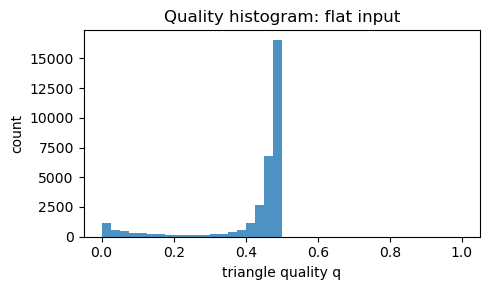

In [28]:
# 1) baseline QA

stats0 = mesh_report(normalized_mesh_sliced_all, name="flat input", plot=True)

In [29]:
# # 2) MMG remesh caps
# mesh_mmg = remesh_caps_with_mmg(normalized_mesh_sliced_all, h_cap=0.10, hausd=None, mmgs_bin="mmgs_O3")
# stats_mmg = mesh_report(mesh_mmg, name="MMG caps", plot=True)
# view_surface(mesh_mmg.vertices, mesh_mmg.faces, title="MMG caps")

# # 3) PyMeshLab remesh caps
# mesh_pml = remesh_caps_with_pymeshlab(normalized_mesh_sliced_all, h_cap=0.02, iterations=6)
# stats_pml = mesh_report(mesh_pml, name="PyMeshLab caps", plot=True)
# view_surface(mesh_pml.vertices, mesh_pml.faces, title="PyMeshLab caps")


In [30]:
# # only pymeshlab now

# def remesh_caps_with_pymeshlab(mesh_in: trimesh.Trimesh,
#                                h_cap: float,
#                                iterations: int = 5) -> trimesh.Trimesh:
#     """
#     Remesh each planar patch using PyMeshLab 'meshing_isotropic_explicit_remeshing'
#     with preserveboundary=True. Only replaces faces on the six planes.
#     """
#     m = mesh_in.copy()
#     V, F = m.vertices.copy(), m.faces.copy()

#     def _remesh_patch_pyml(Vp, Fp):
#         ms = ml.MeshSet()
#         ms.add_mesh(ml.Mesh(Vp, Fp))
#         print(f"target length percentage: {h_cap*100:.1f}%")
#         ms.meshing_isotropic_explicit_remeshing(targetlen=ml.PercentageValue(h_cap*100),
#                                                 iterations=iterations,
#                                                 #preservenormal=True,
#                                                 #preserveboundary=True
#                                                 )
#         mrem = ms.current_mesh()
#         return np.asarray(mrem.vertex_matrix(), float), np.asarray(mrem.face_matrix(), int)

#     for axis, side in [('x','min'),('x','max'),('y','min'),('y','max'),('z','min'),('z','max')]:
#         ax = {'x':0,'y':1,'z':2}[axis]
#         val = (m.bounds[0][ax] if side=='min' else m.bounds[1][ax])
#         face_idx = _faces_on_plane(m, axis, val, tol=1e-12)
#         if len(face_idx)==0:
#             print(f"[pml {axis} {side}] no faces; skip")
#             continue

#         print(f"[pml {axis} {side}] input patch faces: {len(face_idx)}")
#         patch = m.submesh([face_idx], append=True, repair=False)
#         Vp0, Fp0 = patch.vertices, patch.faces

#         Vp, Fp = _remesh_patch_pyml(Vp0, Fp0)

#         # Boundary map: identify boundary rings in old and new, then map by coordinate
#         def boundary_indices(Vp, Fp):
#             E = np.sort(np.vstack([Fp[:,[0,1]],Fp[:,[1,2]],Fp[:,[2,0]]]), axis=1)
#             e_u, c = np.unique(E, axis=0, return_counts=True)
#             bnd = np.unique(e_u[c==1].ravel())
#             return bnd

#         b0 = boundary_indices(Vp0, Fp0)
#         b1 = boundary_indices(Vp,  Fp)
#         # map b1 -> global seam via KDTree in the full mesh
#         on_plane = np.isclose(m.vertices[:,ax], float(val), atol=1e-12)
#         seam_global = m.vertices[on_plane]
#         from scipy.spatial import cKDTree
#         tree = cKDTree(seam_global)
#         dist, idx = tree.query(Vp[b1], k=1)
#         if np.max(dist) > 1e-7:
#             print(f"[pml {axis} {side}] WARNING: boundary mapping dist up to {np.max(dist):.3e}")
#         glob_ids = np.nonzero(on_plane)[0][idx]
#         b1_to_glob = { int(b1[i]): int(glob_ids[i]) for i in range(len(b1)) }

#         # stitch: interior verts appended
#         map_local = {}
#         int_list = []
#         for li in range(len(Vp)):
#             if li in b1_to_glob:
#                 map_local[li] = b1_to_glob[li]
#             else:
#                 map_local[li] = len(V) + len(int_list)
#                 int_list.append(li)
#         if int_list:
#             V = np.vstack([V, Vp[int_list]])

#         Fnew = np.vectorize(lambda x: map_local[int(x)])(Fp)
#         keep = np.ones(len(F), bool); keep[face_idx] = False
#         F = np.vstack([F[keep], Fnew])

#         m = trimesh.Trimesh(vertices=V, faces=F, process=False)
#         print(f"[pml {axis} {side}] replaced: V={len(V):,} F={len(F):,} watertight={m.is_watertight}")

#     return m

target length percentage: 1.0%

Geometric measures:
  avg_edge_inc_faux_length: 0.017244070131740414
  avg_edge_length: 0.017244070131740414
  axis_momenta: [-0.04933856  0.04033586  0.13668552]
  barycenter: [0.46579815 0.45708279 0.54650341]
  bbox: <pymeshlab.pmeshlab.BoundingBox object at 0x7f5b5c2f8030>
  center_of_mass: [0.52543339 0.12183236 0.15067284]
  inertia_tensor: [[ 0.04267495 -0.08568159  0.00711559]
 [-0.08568159  0.03918805 -0.03538335]
 [ 0.00711559 -0.03538335  0.04581983]]
  mesh_volume: 0.28210056085014124
  pca: [[-0.6556972  -0.722389   -0.21957986]
 [-0.38161772  0.06614711  0.92195036]
 [ 0.65148223 -0.68831584  0.31904892]]
  shell_barycenter: [0.46665002 0.45622736 0.54826928]
  surface_area: 6.5750346183776855
  total_edge_inc_faux_length: 1362.6264218101276
  total_edge_length: 1362.6264218101276

Topological measures:
  boundary_edges: 0
  connected_components_number: 1
  edges_number: 79020
  faces_number: 52680
  genus: 33
  incident_faces_on_non_two_ma

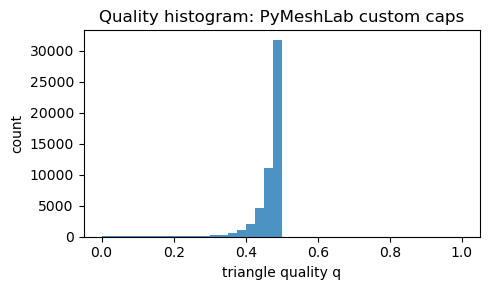

Widget(value='<iframe src="http://localhost:42663/index.html?ui=P_0x7f5b641ebed0_8&reconnect=auto" class="pyvi…

<trimesh.Trimesh(vertices.shape=(16514, 3), faces.shape=(33156, 3))>

In [31]:
def minimal_pymeshlab_pipeline(mesh_in: trimesh.Trimesh,
                               h_cap: float,
                               iterations: int = 5) -> trimesh.Trimesh:

    m = mesh_in.copy()
    V, F = m.vertices.copy(), m.faces.copy()

    ms = ml.MeshSet()
    ms.add_mesh(ml.Mesh(V, F))
    print(f"target length percentage: {h_cap*100:.1f}%")
    ms.meshing_isotropic_explicit_remeshing(targetlen=ml.PercentageValue(h_cap*100),
                                            iterations=iterations,
                                            adaptive=False,
                                            reprojectflag=True
                                            )

    ms.meshing_remove_duplicate_vertices()
    ms.meshing_remove_duplicate_faces()
    ms.meshing_remove_null_faces()
    ms.meshing_remove_unreferenced_vertices()
    ms.meshing_repair_non_manifold_edges()
    ms.meshing_repair_non_manifold_vertices()
    geo_measures = ms.get_geometric_measures()
    topo_measures = ms.get_topological_measures()
    print("\nGeometric measures:")
    for k, v in geo_measures.items():
        print(f"  {k}: {v}")
    print("\nTopological measures:")
    for k, v in topo_measures.items():
        print(f"  {k}: {v}")

    mrem = ms.current_mesh()
    return np.asarray(mrem.vertex_matrix(), float), \
            np.asarray(mrem.face_matrix(), int), \
            trimesh.Trimesh(vertices=np.asarray(mrem.vertex_matrix(), float), \
                            faces=np.asarray(mrem.face_matrix(), int), \
                            process=False)

h_cap = 0.01
iterations = 6  

V_custom, F_custom, mesh_custom = minimal_pymeshlab_pipeline(normalized_mesh_sliced_all, h_cap=h_cap, iterations=iterations)
stats_pml = mesh_report(mesh_custom, name="PyMeshLab custom caps", plot=True)
view_surface(mesh_custom.vertices, mesh_custom.faces, title="PyMeshLab custom caps")

mesh

In [32]:
def _as_ml_mesh(m: trimesh.Trimesh) -> ml.Mesh:
    V = np.asarray(m.vertices, float)
    F = np.asarray(m.faces,    int)
    return ml.Mesh(V, F)

def _from_ml_mesh(m: ml.Mesh) -> trimesh.Trimesh:
    V = np.asarray(m.vertex_matrix(), float)
    F = np.asarray(m.face_matrix(),   int)
    return trimesh.Trimesh(vertices=V, faces=F, process=False)

#! this implementation below does translation only, no reflection

# def fuse_tiles_2x2x2_pml(
#     base_mesh: trimesh.Trimesh,
#     L=(1.0, 1.0, 1.0),               # box size of your normalized RVE
#     weld_tol=1e-9,                   # absolute length (same units as vertices)
#     snap_thresh=1e-6,                # border snapping threshold
#     verbose=True
# ) -> trimesh.Trimesh:
#     """
#     Make an exact 2x2x2 tiling of `base_mesh` by pure translations and fuse it
#     into a single surface with welded seams.

#     Assumptions:
#     - base_mesh is already flat on x,y,z planes at ~[0, Lx] x [0, Ly] x [0, Lz]
#     - you want identical copies (no reflections) -> true periodicity by translation
#     """
#     if verbose:
#         bbmin, bbmax = base_mesh.bounds
#         print(f"[tile] input bbox min={bbmin}, max={bbmax}")

#     # safety: ensure we are in [0,L]^3 up to a tiny tolerance
#     eps = 1e-12
#     if not (np.all(bbmin >= -eps) and np.all(np.abs(bbmax - np.array(L)) <= 1e-6)):
#         print("[tile][warn] bbox is not ~[0,L]; continuing anyway (we translate your vertices as-is).")

#     # prepare all 8 tiles with exact translations (integer multiples of L)
#     tiles = []
#     V0 = np.asarray(base_mesh.vertices, float)
#     F0 = np.asarray(base_mesh.faces,    int)



#     ## old code

#     for ix in (0, 1):
#         for iy in (0, 1):
#             for iz in (0, 1):
#                 shift = np.array([ix*L[0], iy*L[1], iz*L[2]], float)
#                 Vi = V0 + shift
#                 tiles.append(ml.Mesh(Vi, F0))
#                 if verbose:
#                     print(f"[tile] copy shift=({ix},{iy},{iz}) -> +{shift.tolist()}")

#     # load tiles as separate layers
#     ms = ml.MeshSet()
#     for k, m in enumerate(tiles):
#         ms.add_mesh(m, f"tile_{k}")

#     # merge all visible layers into one mesh
#     ms.generate_by_merging_visible_meshes()
#     if verbose:
#         cm = ms.current_mesh()
#         print(f"[merge] after merge: V={cm.vertex_number()}, F={cm.face_number()}")

#     # exact duplicate cleanup first (cheap, deterministic)
#     ms.meshing_remove_duplicate_vertices()
#     ms.meshing_remove_duplicate_faces()

#     # weld vertices closer than weld_tol
#     ms.meshing_merge_close_vertices(threshold=ml.PercentageValue(weld_tol))
#     # optional: non-manifold fix pass
#     ms.meshing_repair_non_manifold_edges()
#     ms.meshing_repair_non_manifold_vertices()



#     out_tm = _from_ml_mesh(ms.current_mesh())
#     if verbose:
#         print(f"[fuse] fused mesh: watertight={out_tm.is_watertight}, "
#               f"V={len(out_tm.vertices):,}, F={len(out_tm.faces):,}")
#     return out_tm



#!!! this implementation below does translation and reflection. 

# def fuse_tiles_2x2x2_pml(
#     base_mesh: trimesh.Trimesh,
#     L=(1.0, 1.0, 1.0),               # (kept for signature; reflections assume [0,1]^3)
#     weld_tol=1e-9,                   # absolute length (same units as vertices)
#     snap_thresh=1e-6,                # border snapping threshold
#     verbose=True
# ) -> trimesh.Trimesh:
#     """
#     Build a 2x2x2 tiling by REFLECTION across x=1, y=1, z=1 planes.
#     - If input bbox ≠ [0,1]^3, normalize to [0,1]^3 first.
#     - For each axis with reflection, apply coord := 2 - coord.
#     - For an odd number of reflections, reverse face winding.
#     Then fuse by merging layers and welding vertices.
#     """
#     if verbose:
#         bbmin, bbmax = base_mesh.bounds
#         print(f"[tile] input bbox min={bbmin}, max={bbmax}")

#     # --- normalize to [0,1]^3 if needed ---
#     eps = 1e-12
#     V0 = np.asarray(base_mesh.vertices, float).copy()
#     F0 = np.asarray(base_mesh.faces,    int)
#     vmin = V0.min(axis=0)
#     vmax = V0.max(axis=0)
#     ext  = vmax - vmin
#     if not (np.allclose(vmin, 0.0, atol=1e-6) and np.allclose(vmax, 1.0, atol=1e-6)):
#         if verbose:
#             print(f"[tile] normalizing to [0,1]^3 from [{vmin}] -> [{vmax}]")
#         ext[ext == 0.0] = 1.0
#         V0 = (V0 - vmin) / ext
#     else:
#         if verbose:
#             print("[tile] already ~[0,1]^3")

#     # --- build 8 reflected tiles (no translations needed) ---
#     tiles = []
#     for ix in (0, 1):
#         for iy in (0, 1):
#             for iz in (0, 1):
#                 Vi = V0.copy()
#                 flips = (ix, iy, iz)
#                 if ix == 1: Vi[:, 0] = 2.0 - Vi[:, 0]
#                 if iy == 1: Vi[:, 1] = 2.0 - Vi[:, 1]
#                 if iz == 1: Vi[:, 2] = 2.0 - Vi[:, 2]
#                 # orientation: flip winding if odd number of reflections
#                 if (ix + iy + iz) % 2 == 1:
#                     Fi = F0[:, [0, 2, 1]]
#                 else:
#                     Fi = F0
#                 tiles.append(ml.Mesh(Vi, Fi))
#                 if verbose:
#                     print(f"[tile] reflect (ix,iy,iz)={flips}  -> "
#                           f"x:{'2-x' if ix else 'x'}, y:{'2-y' if iy else 'y'}, z:{'2-z' if iz else 'z'}")

#     # --- load tiles as layers ---
#     ms = ml.MeshSet()
#     for k, m in enumerate(tiles):
#         ms.add_mesh(m, f"tile_{k}")

#     # --- fuse: merge + dedup + weld + repairs ---
#     ms.generate_by_merging_visible_meshes()
#     if verbose:
#         cm = ms.current_mesh()
#         print(f"[merge] after merge: V={cm.vertex_number()}, F={cm.face_number()}")

#     ms.meshing_remove_duplicate_vertices()
#     ms.meshing_remove_duplicate_faces()
#     ms.meshing_merge_close_vertices(threshold=ml.PercentageValue(weld_tol))
#     ms.meshing_repair_non_manifold_edges()
#     ms.meshing_repair_non_manifold_vertices()

#     # geometric and topological measures
#     geo_measures = ms.get_geometric_measures()
#     topo_measures = ms.get_topological_measures()
#     if verbose:
#         print("\nGeometric measures:")
#         for k, v in geo_measures.items():
#             print(f"  {k}: {v}")
#         print("\nTopological measures:")
#         for k, v in topo_measures.items():
#             print(f"  {k}: {v}")

#     # optional: if tiny gaps remain, snap borders
#     # ms.meshing_snap_mismatched_borders(threshold=snap_thresh)

#     out_tm = _from_ml_mesh(ms.current_mesh())
#     if verbose:
#         print(f"[fuse] fused mesh: watertight={out_tm.is_watertight}, "
#               f"V={len(out_tm.vertices):,}, F={len(out_tm.faces):,}")
#     return out_tm


In [33]:
def fuse_tiles_2x2x2_pml_reflection(
    base_mesh: trimesh.Trimesh,
    L=(1.0, 1.0, 1.0),               # box size of your normalized RVE
    weld_tol=1e-9,                   # absolute length (same units as vertices)
    snap_thresh=1e-6,                # border snapping threshold
    verbose=True
) -> trimesh.Trimesh:
    """
    Make an exact 2x2x2 tiling of `base_mesh` by pure translations and fuse it
    into a single surface with welded seams.

    Assumptions:
    - base_mesh is already flat on x,y,z planes at ~[0, Lx] x [0, Ly] x [0, Lz]
    - you want identical copies (no reflections) -> true periodicity by translation
    """
    if verbose:
        bbmin, bbmax = base_mesh.bounds
        print(f"[tile] input bbox min={bbmin}, max={bbmax}")

    # safety: ensure we are in [0,L]^3 up to a tiny tolerance
    eps = 1e-12
    if not (np.all(bbmin >= -eps) and np.all(np.abs(bbmax - np.array(L)) <= 1e-6)):
        print("[tile][warn] bbox is not ~[0,L]; continuing anyway (we translate your vertices as-is).")

    # prepare all 8 tiles with exact translations (integer multiples of L)


    # first in x
    tiles_x = []
    V0 = np.asarray(base_mesh.vertices, float)
    F0 = np.asarray(base_mesh.faces,    int)
    tiles_x.append(ml.Mesh(V0, F0)) # original

    shift_x = np.array([2,0,0], float)
    V0x = np.stack((2 - V0[:,0], V0[:,1], V0[:,2]), axis=-1)
    print(V0[:5,:])
    print(V0x[:5,:])
    assert V0.shape == V0x.shape
    tiles_x.append(ml.Mesh(V0x, F0))

    ms_x = ml.MeshSet()
    for k, m in enumerate(tiles_x):
        ms_x.add_mesh(m, f"tile_x_{k}")
    ms_x.generate_by_merging_visible_meshes()
    ms_x.meshing_remove_duplicate_vertices()
    ms_x.meshing_remove_duplicate_faces()
    ms_x.meshing_merge_close_vertices(threshold=ml.PercentageValue(weld_tol))
    ms_x.meshing_repair_non_manifold_edges()
    ms_x.meshing_repair_non_manifold_vertices()

    # print geo/topo and viz
    if verbose:
        cm = ms_x.current_mesh()
        print(f"[merge x] after merge: V={cm.vertex_number()}, F={cm.face_number()}")
        print(f"[merge x] watertight? {trimesh.Trimesh(cm.vertex_matrix(), cm.face_matrix()).is_watertight}")
        geo_measures = ms_x.get_geometric_measures()
        topo_measures = ms_x.get_topological_measures()
        print("\nGeometric measures:")
        for k, v in geo_measures.items():
            print(f"  {k}: {v}")
        print("\nTopological measures:")
        for k, v in topo_measures.items():
            print(f"  {k}: {v}")
        mesh_report_x = mesh_report(_from_ml_mesh(cm), name="[merge x] report", plot=False)
        view_surface(np.asarray(cm.vertex_matrix(), float), np.asarray(cm.face_matrix(), int), title="after x-merge")

    # now in y 
    tiles_y = []
    V0y = np.asarray(ms_x.current_mesh().vertex_matrix(), float)
    F0y = np.asarray(ms_x.current_mesh().face_matrix(),    int)
    tiles_y.append(ml.Mesh(V0y, F0y)) # original

    shift_y = np.array([0,2,0], float)
    V0y2 = np.stack((V0y[:,0], 2 - V0y[:,1], V0y[:,2]), axis=-1)
    assert V0y.shape == V0y2.shape
    tiles_y.append(ml.Mesh(V0y2, F0y))

    ms_y = ml.MeshSet()
    for k, m in enumerate(tiles_y):
        ms_y.add_mesh(m, f"tile_y_{k}")
    ms_y.generate_by_merging_visible_meshes()
    ms_y.meshing_remove_duplicate_vertices()
    ms_y.meshing_remove_duplicate_faces()   
    ms_y.meshing_merge_close_vertices(threshold=ml.PercentageValue(weld_tol))
    ms_y.meshing_repair_non_manifold_edges()
    ms_y.meshing_repair_non_manifold_vertices()

    if verbose:
        cm = ms_y.current_mesh()
        print(f"[merge y] after merge: V={cm.vertex_number()}, F={cm.face_number()}")
        geo_measures = ms_y.get_geometric_measures()
        topo_measures = ms_y.get_topological_measures()
        print("\nGeometric measures:")
        for k, v in geo_measures.items():
            print(f"  {k}: {v}")
        print("\nTopological measures:")
        for k, v in topo_measures.items():
            print(f"  {k}: {v}")
        view_surface(np.asarray(cm.vertex_matrix(), float), np.asarray(cm.face_matrix(), int), title="after y-merge")

    # finally in z
    tiles_z = []
    V0z = np.asarray(ms_y.current_mesh().vertex_matrix(), float)
    F0z = np.asarray(ms_y.current_mesh().face_matrix(),    int)
    tiles_z.append(ml.Mesh(V0z, F0z)) # original    

    shift_z = np.array([0,0,2], float)
    V0z2 = np.stack((V0z[:,0], V0z[:,1], 2 - V0z[:,2]), axis=-1)
    assert V0z.shape == V0z2.shape
    tiles_z.append(ml.Mesh(V0z2, F0z))

    ms_z = ml.MeshSet()
    for k, m in enumerate(tiles_z):
        ms_z.add_mesh(m, f"tile_z_{k}")
    ms_z.generate_by_merging_visible_meshes()
    ms_z.meshing_remove_duplicate_vertices()
    ms_z.meshing_remove_duplicate_faces()   
    ms_z.meshing_merge_close_vertices(threshold=ml.PercentageValue(weld_tol))
    ms_z.meshing_repair_non_manifold_edges()
    ms_z.meshing_repair_non_manifold_vertices()

    if verbose:
        cm = ms_z.current_mesh()
        print(f"[merge z] after merge: V={cm.vertex_number()}, F={cm.face_number()}")
        geo_measures = ms_z.get_geometric_measures()
        topo_measures = ms_z.get_topological_measures()
        print("\nGeometric measures:")
        for k, v in geo_measures.items():
            print(f"  {k}: {v}")
        print("\nTopological measures:")
        for k, v in topo_measures.items():
            print(f"  {k}: {v}")
        view_surface(np.asarray(cm.vertex_matrix(), float), np.asarray(cm.face_matrix(), int), title="after z-merge")

    out_tm = _from_ml_mesh(ms_z.current_mesh())
    if verbose:
        print(f"[fuse] fused mesh: watertight={out_tm.is_watertight}, "
              f"V={len(out_tm.vertices):,}, F={len(out_tm.faces):,}")
    return out_tm


In [34]:
import json
from collections import defaultdict

def periodic_node_map_from_planes(mesh_single: trimesh.Trimesh,
                                  tol: float = 1e-12) -> dict:
    """
    Build exact node maps between opposite planes by coordinate equality.
    Returns dict with keys 'x','y','z' each mapping to list of [slave_idx, master_idx].
    Assumes mesh_single is already flattened to x=0/1, y=0/1, z=0/1.
    """
    V = mesh_single.vertices.view(np.ndarray)
    eps = tol

    def plane_pairs(axis, v0, v1):
        a = {'x':0, 'y':1, 'z':2}[axis]
        other = [i for i in range(3) if i != a]
        I0 = np.where(np.isclose(V[:,a], v0, atol=eps))[0]
        I1 = np.where(np.isclose(V[:,a], v1, atol=eps))[0]
        if len(I0) != len(I1):
            print(f"[periodic] {axis}: count mismatch: {len(I0)} vs {len(I1)}")
        # match by the other two coordinates
        key = lambda p: (round(V[p,other[0]]/eps)*eps, round(V[p,other[1]]/eps)*eps)
        m0 = defaultdict(list)
        for i in I0: m0[key(i)].append(i)
        pairs = []
        for j in I1:
            k = key(j)
            if k not in m0 or len(m0[k]) == 0:
                # fallback: nearest neighbor among I0 on the plane
                P0 = V[I0][:,other]
                idx = np.argmin(np.linalg.norm(P0 - V[j,other], axis=1))
                pairs.append([int(j), int(I0[idx])])
            else:
                pairs.append([int(j), int(m0[k].pop())])
        # sanity
        slave = V[[p[0] for p in pairs]]
        master = V[[p[1] for p in pairs]].copy()
        master[:,a] = v1  # so that slave and transformed master are identical
        err = np.max(np.abs(slave - master))
        print(f"[periodic] {axis}-map pairs={len(pairs)}, max |slave-master| = {err:.3e}")
        return pairs

    maps = {
        'x': plane_pairs('x', 0.0, 1.0),
        'y': plane_pairs('y', 0.0, 1.0),
        'z': plane_pairs('z', 0.0, 1.0),
    }
    return maps

def save_periodic_map_json(maps: dict, path: str):
    with open(path, "w") as f:
        json.dump(maps, f, indent=2)
    print(f"[periodic] saved node map to {path}")


In [35]:
# base = your *flat & remeshed* single-cell mesh (trimesh.Trimesh), e.g. from PyMeshLab
# L = (0.98, 0.98, 0.98)  # if you normalized to [0.01,0.99], set L accordingly
# mesh_2x2x2 = fuse_tiles_2x2x2_pml(mesh_custom, L=L, weld_tol=1e-9, snap_thresh=1e-6, verbose=True)

# visualize with your helper
# view_surface(mesh_2x2x2.vertices, mesh_2x2x2.faces, title="2x2x2 fused (PyMeshLab)")

# 3) Build periodic map on the single cell and save
# pmap = periodic_node_map_from_planes(mesh_single, tol=1e-12)
# save_periodic_map_json(pmap, "periodic_maps.json")

In [36]:
# L = (0.98, 0.98, 0.98)  # if you normalized to [0.01,0.99], set L accordingly

normalized_remeshed_nodes = (mesh_custom.vertices - mesh_custom.vertices.min(axis=0)) /  (mesh_custom.vertices.max(axis=0) - mesh_custom.vertices.min(axis=0))
normalized_remeshed_mesh = trimesh.Trimesh(vertices=normalized_remeshed_nodes, faces=mesh_custom.faces, process=False)
view_surface(normalized_remeshed_mesh.vertices, normalized_remeshed_mesh.faces, title="normalized")

mesh_2x2x2_reflection = fuse_tiles_2x2x2_pml_reflection(normalized_remeshed_mesh, weld_tol=1e-9, snap_thresh=1e-6, verbose=True)

# visualize with your helper
view_surface(mesh_2x2x2_reflection.vertices, mesh_2x2x2_reflection.faces, title="2x2x2 fused and reflected (PyMeshLab)")

Widget(value='<iframe src="http://localhost:42663/index.html?ui=P_0x7f5b64194090_9&reconnect=auto" class="pyvi…

[tile] input bbox min=[0. 0. 0.], max=[1. 1. 1.]
[[0.38431948 0.21957012 0.83122155]
 [0.17014018 0.24801639 0.03531757]
 [0.84774484 0.38252524 0.36257663]
 [0.29279607 0.4899967  0.22298816]
 [0.92824686 0.23486046 0.70585939]]
[[1.61568052 0.21957012 0.83122155]
 [1.82985982 0.24801639 0.03531757]
 [1.15225516 0.38252524 0.36257663]
 [1.70720393 0.4899967  0.22298816]
 [1.07175314 0.23486046 0.70585939]]
[merge x] after merge: V=51425, F=102868
[merge x] watertight? False

Geometric measures:
  avg_edge_inc_faux_length: 0.017610656732290935
  avg_edge_length: 0.017610656732290935
  barycenter: [0.99999999 0.45291343 0.54888465]
  bbox: <pymeshlab.pmeshlab.BoundingBox object at 0x7f5b5c2793b0>
  pca: [[ 1.35544110e-09 -8.61886714e-09  1.00000000e+00]
 [ 7.52139639e-01  6.59003766e-01  4.66038492e-09]
 [-6.59003766e-01  7.52139639e-01  7.37583241e-09]]
  shell_barycenter: [1.00000034 0.45204189 0.55060238]
  surface_area: 13.404694557189941
  total_edge_inc_faux_length: 2723.012575917

Widget(value='<iframe src="http://localhost:42663/index.html?ui=P_0x7f5b5c27aa90_10&reconnect=auto" class="pyv…

[merge y] after merge: V=101649, F=203097

Geometric measures:
  avg_edge_inc_faux_length: 0.017619840286503957
  avg_edge_length: 0.017619840286503957
  barycenter: [1.00000436 0.99999987 0.54651023]
  bbox: <pymeshlab.pmeshlab.BoundingBox object at 0x7f5bc4434830>
  pca: [[ 3.51522577e-06  6.23702002e-11  1.00000000e+00]
 [ 1.63508739e-07 -1.00000000e+00  6.17954300e-11]
 [-1.00000000e+00 -1.63508739e-07  3.51522577e-06]]
  shell_barycenter: [1.00000037 1.00000024 0.54826851]
  surface_area: 26.507869720458984
  total_edge_inc_faux_length: 5385.345605007356
  total_edge_length: 5385.345605007356

Topological measures:
  boundary_edges: 1991
  connected_components_number: 2
  edges_number: 305641
  faces_number: 203097
  genus: -1
  incident_faces_on_non_two_manifold_edges: 0
  incident_faces_on_non_two_manifold_vertices: 12
  is_mesh_two_manifold: False
  non_two_manifold_edges: 0
  non_two_manifold_vertices: 3
  number_holes: -1
  unreferenced_vertices: 0
  vertices_number: 101649


Widget(value='<iframe src="http://localhost:42663/index.html?ui=P_0x7f5bc4434a50_11&reconnect=auto" class="pyv…

[merge z] after merge: V=200228, F=399351

Geometric measures:
  avg_edge_inc_faux_length: 0.017636142772177055
  avg_edge_length: 0.017636142772177055
  barycenter: [1.00005633 1.00002305 0.99999996]
  bbox: <pymeshlab.pmeshlab.BoundingBox object at 0x7f5bc44d09f0>
  pca: [[ 3.54485834e-08 -2.26834162e-03  9.99997427e-01]
 [-2.40517179e-07  9.99997427e-01  2.26834162e-03]
 [-1.00000000e+00 -2.40596969e-07  3.49029170e-08]]
  shell_barycenter: [1.00000047 1.00000025 0.99999968]
  surface_area: 52.25625991821289
  total_edge_inc_faux_length: 10617.275399420487
  total_edge_length: 10617.275399420487

Topological measures:
  boundary_edges: 5983
  connected_components_number: 9
  edges_number: 602018
  faces_number: 399351
  genus: -1
  incident_faces_on_non_two_manifold_edges: 0
  incident_faces_on_non_two_manifold_vertices: 79
  is_mesh_two_manifold: False
  non_two_manifold_edges: 0
  non_two_manifold_vertices: 17
  number_holes: -1
  unreferenced_vertices: 0
  vertices_number: 200228

Widget(value='<iframe src="http://localhost:42663/index.html?ui=P_0x7f5bc44d11d0_12&reconnect=auto" class="pyv…

[fuse] fused mesh: watertight=False, V=200,228, F=399,351


Widget(value='<iframe src="http://localhost:42663/index.html?ui=P_0x7f5bc4434950_13&reconnect=auto" class="pyv…

gpt5

In [41]:

def _triangle_quality(V, F):
    # 2*sqrt(3)*A / sum(l^2); 1 = equilateral
    p0, p1, p2 = V[F[:,0]], V[F[:,1]], V[F[:,2]]
    e0 = np.linalg.norm(p1 - p0, axis=1)
    e1 = np.linalg.norm(p2 - p1, axis=1)
    e2 = np.linalg.norm(p0 - p2, axis=1)
    A  = 0.5*np.linalg.norm(np.cross(p1 - p0, p2 - p0), axis=1)
    denom = e0*e0 + e1*e1 + e2*e2
    with np.errstate(divide='ignore', invalid='ignore'):
        q = (2.0*math.sqrt(3.0))*A/denom
        q[~np.isfinite(q)] = 0.0
    return np.clip(q, 0.0, 1.0)

def _as_ml_mesh(m: trimesh.Trimesh) -> ml.Mesh:
    return ml.Mesh(np.asarray(m.vertices, float), np.asarray(m.faces, int))

def _from_ml_mesh(m: ml.Mesh) -> trimesh.Trimesh:
    return trimesh.Trimesh(
        vertices=np.asarray(m.vertex_matrix(), float),
        faces=np.asarray(m.face_matrix(), int),
        process=False
    )

# def _manifold_edge_stats(tm: trimesh.Trimesh):
#     # edges_unique_faces: object array of lists (each list = incident faces indices)
#     e_faces = tm.edges_unique_faces
#     bnd = sum(1 for ef in e_faces if len(ef) == 1)
#     nonman = sum(1 for ef in e_faces if len(ef) > 2)
#     return bnd, nonman

def _genus(tm: trimesh.Trimesh):
    # Only meaningful if watertight and orientable
    if not tm.is_watertight:
        return None
    # euler_number present in trimesh
    chi = tm.euler_number
    # For single closed orientable surface: chi = 2 - 2g -> g = (2 - chi)/2
    return (2 - chi)/2

def _print_trimesh_stats(tm: trimesh.Trimesh, label: str, plot_quality_hist=False):
    V = tm.vertices; F = tm.faces
    print(f"\n=== {label} (trimesh diagnostics) ===")
    print(f"verts={len(V):,} faces={len(F):,}")
    print(f"bbox min={tm.bounds[0]}  max={tm.bounds[1]}  extents={tm.extents}")
    print(f"surface area={tm.area:.6g}")
    if tm.is_watertight:
        print(f"volume={tm.volume:.6g}")
    else:
        print("volume=N/A (not watertight)")
    # bnd, nonman = _manifold_edge_stats(tm)
    print(f"watertight={tm.is_watertight}  winding_consistent={tm.is_winding_consistent}")
    # print(f"boundary_edges={bnd}  nonmanifold_edges={nonman}")
    g = _genus(tm)
    print(f"genus={g if g is not None else 'N/A'}  euler_number={tm.euler_number}")
    # duplicates
    sF = np.sort(F, axis=1)
    _, idx = np.unique(sF, axis=0, return_index=True)
    dup_faces = len(F) - len(idx)
    key = np.round(V/1e-12).astype(np.int64)
    _, vidx = np.unique(key, axis=0, return_index=True)
    dup_verts = len(V) - len(vidx)
    print(f"duplicate_faces={dup_faces} duplicate_vertices(1e-12 snap)={dup_verts}")
    # quality
    q = _triangle_quality(V, F)
    qs = dict(
        min=float(q.min()),
        p5=float(np.percentile(q,5)),
        mean=float(q.mean()),
        p95=float(np.percentile(q,95)),
        max=float(q.max())
    )
    print("triangle_quality q: "
          f"min={qs['min']:.3f} p5={qs['p5']:.3f} mean={qs['mean']:.3f} "
          f"p95={qs['p95']:.3f} max={qs['max']:.3f}")
    if plot_quality_hist:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(5,3))
        plt.hist(q, bins=40, range=(0,1), alpha=0.8)
        plt.xlabel("triangle quality q")
        plt.ylabel("count")
        plt.title(f"Quality: {label}")
        plt.tight_layout()
        plt.show()
    return {
        "verts": len(V),
        "faces": len(F),
        "watertight": tm.is_watertight,
        # "boundary_edges": bnd,
        # "nonmanifold_edges": nonman,
        "genus": g,
        "euler_number": tm.euler_number
    }

def _pml_measures(ms: ml.MeshSet, label: str):
    g = ms.get_geometric_measures()
    t = ms.get_topological_measures()
    print(f"\n--- {label} (PyMeshLab measures) ---")
    for k,v in g.items():
        print(f"[geo] {k}: {v}")
    for k,v in t.items():
        print(f"[topo] {k}: {v}")
    return g, t

def _weld_trimesh(tm: trimesh.Trimesh, weld_abs: float):
    V = tm.vertices.copy()
    F = tm.faces.copy()
    if weld_abs <= 0:
        return tm
    key = np.round(V / weld_abs).astype(np.int64)
    _, keep, inv = np.unique(key, axis=0, return_index=True, return_inverse=True)
    Vw = V[keep]
    Fw = inv[F]
    # remove degenerate & duplicate
    keepf = (Fw[:,0]!=Fw[:,1]) & (Fw[:,0]!=Fw[:,2]) & (Fw[:,1]!=Fw[:,2])
    Fw = Fw[keepf]
    sF = np.sort(Fw,axis=1)
    _, uidx = np.unique(sF, axis=0, return_index=True)
    Fw = Fw[np.sort(uidx)]
    return trimesh.Trimesh(Vw, Fw, process=False)

def _pair_planes(mesh: trimesh.Trimesh, axis: str, L: float, tol: float, quant: float):
    a = {'x':0,'y':1,'z':2}[axis]
    other = [i for i in range(3) if i != a]
    V = mesh.vertices
    I0 = np.where(np.isclose(V[:,a], 0.0, atol=tol))[0]
    I2 = np.where(np.isclose(V[:,a], L,   atol=tol))[0]
    def key(i):
        return (int(round(V[i,other[0]]/quant)),
                int(round(V[i,other[1]]/quant)))
    buckets = {}
    for i in I0:
        buckets.setdefault(key(i), []).append(i)
    pairs=[]
    missed=0
    for j in I2:
        k = key(j)
        if k in buckets and buckets[k]:
            pairs.append([buckets[k].pop(), j])  # [min_plane, max_plane]
        else:
            missed+=1
            # fallback nearest
            if len(I0):
                d = np.linalg.norm(V[I0][:,other]-V[j,other], axis=1)
                pairs.append([I0[np.argmin(d)], j])
    print(f"[pair {axis}] pairs={len(pairs)} fallback={missed} I0={len(I0)} I{L}={len(I2)}")
    return pairs

# ---------- Main Function ----------

def build_periodic_reflected_2x2x2_with_logs(
    base_mesh: trimesh.Trimesh,
    normalize: bool = True,
    weld_abs: float = 1e-6,
    pair_tol: float = 1e-8,
    pair_quant: float | None = None,
    show_quality_hist: bool = False,
    show_views: bool = True
):
    """
    Construct a 2x2x2 periodic supercell by successive reflections (X, then Y, then Z),
    logging geometric & topological stats (PyMeshLab + custom trimesh) at each stage.

    Steps:
      0. (Optional) normalize input to [0,1]^3.
      1. Reflect across x=1 -> combine (domain [0,2]x[0,1]x[0,1])
      2. Reflect result across y=1 -> combine (domain [0,2]^2x[0,1])
      3. Reflect result across z=1 -> combine (domain [0,2]^3)
      4. Final welding + cleanup
      5. Build periodic node pairings for planes 0 and 2 in each axis.

    Returns:
      supercell (trimesh.Trimesh),
      pairing dict {'x': [[imin,imax],...], 'y': [...], 'z': [...]},
      logs (dict of intermediate stats)
    """
    if not isinstance(base_mesh, trimesh.Trimesh):
        raise TypeError("base_mesh must be a trimesh.Trimesh")

    logs = {}

    # Step 0: initial and normalization
    mesh0 = base_mesh.copy()
    if normalize:
        vmin = mesh0.vertices.min(axis=0)
        vmax = mesh0.vertices.max(axis=0)
        ext  = vmax - vmin
        ext[ext == 0.0] = 1.0
        Vn = (mesh0.vertices - vmin)/ext
        mesh0 = trimesh.Trimesh(Vn, mesh0.faces.copy(), process=False)
        print("[norm] normalized to [0,1]^3")
    else:
        print("[norm] skipped (using original coordinates)")
    _print_trimesh_stats(mesh0, "Step0_input", plot_quality_hist=show_quality_hist)
    if show_views: 
        try: view_surface(mesh0.vertices, mesh0.faces, title="Step0_input")
        except Exception: pass
    logs["step0"] = {"bbox": mesh0.bounds.tolist()}

    # Helper to do a single reflection merge with PyMeshLab
    def reflect_merge(prev_mesh: trimesh.Trimesh, axis: str, weld_abs_local: float, step_label: str):
        axis_idx = {'x':0,'y':1,'z':2}[axis]
        # Original
        V0 = prev_mesh.vertices
        F0 = prev_mesh.faces
        # Reflected copy
        Vr = V0.copy()
        Vr[:, axis_idx] = 2.0 - Vr[:, axis_idx]
        # Orientation flip for reflected tile (odd single reflection)
        Fr = F0[:, [0,2,1]]
        m_orig = ml.Mesh(V0, F0)
        m_refl = ml.Mesh(Vr, Fr)

        ms = ml.MeshSet()
        ms.add_mesh(m_orig, f"{step_label}_orig")
        ms.add_mesh(m_refl, f"{step_label}_refl")
        ms.generate_by_merging_visible_meshes()
        # Cleanup
        ms.meshing_remove_duplicate_vertices()
        ms.meshing_remove_duplicate_faces()

        # Absolute welding if supported, else convert to percentage
        diag = float(np.linalg.norm(prev_mesh.bounds[1]-prev_mesh.bounds[0]))
        diag = max(diag, 1e-12)
        try:
            ms.meshing_merge_close_vertices(threshold=ml.AbsoluteValue(weld_abs_local))
        except Exception:
            pct = (weld_abs_local/diag)*100.0
            ms.meshing_merge_close_vertices(threshold=ml.PercentageValue(pct))
        # Non-manifold repairs
        ms.meshing_repair_non_manifold_edges()
        ms.meshing_repair_non_manifold_vertices()

        # Convert to trimesh and ALSO run a stricter manual weld (grid hash) to be safe.
        tm = _from_ml_mesh(ms.current_mesh())
        tm = _weld_trimesh(tm, weld_abs_local)

        # Report
        _pml_measures(ms, f"{step_label}_PyMeshLab")
        _print_trimesh_stats(tm, f"{step_label}_trimesh", plot_quality_hist=show_quality_hist)
        if show_views:
            try: view_surface(tm.vertices, tm.faces, title=step_label)
            except Exception: pass
        return tm

    # Step 1: X reflection
    mesh_x = reflect_merge(mesh0, 'x', weld_abs, "Step1_reflectX")
    logs["step1"] = {"bbox": mesh_x.bounds.tolist()}

    # Step 2: Y reflection
    mesh_xy = reflect_merge(mesh_x, 'y', weld_abs, "Step2_reflectY")
    logs["step2"] = {"bbox": mesh_xy.bounds.tolist()}

    # Step 3: Z reflection
    mesh_xyz = reflect_merge(mesh_xy, 'z', weld_abs, "Step3_reflectZ")
    logs["step3"] = {"bbox": mesh_xyz.bounds.tolist()}

    # Final explicit weld & cleanup pass (idempotent if already clean)
    mesh_final = _weld_trimesh(mesh_xyz, weld_abs)
    mesh_final.remove_unreferenced_vertices()
    # Compute final stats
    _print_trimesh_stats(mesh_final, "Final_supercell", plot_quality_hist=show_quality_hist)
    if show_views:
        try: view_surface(mesh_final.vertices, mesh_final.faces, title="Final_supercell")
        except Exception: pass

    # Periodic pairing (planes at 0 and 2)
    L = 2.0
    if pair_quant is None:
        # choose quant ~ smallest edge * 0.5 (robust) or fallback
        if len(mesh_final.edges_unique):
            edges = mesh_final.edges_unique
            elen = np.linalg.norm(mesh_final.vertices[edges[:,0]] - mesh_final.vertices[edges[:,1]], axis=1)
            pair_quant_local = 0.5 * float(np.min(elen))
        else:
            pair_quant_local = 1e-4
    else:
        pair_quant_local = pair_quant
    print(f"[pair] quantization step = {pair_quant_local:.3e}")

    pairing = {
        'x': _pair_planes(mesh_final, 'x', L, pair_tol, pair_quant_local),
        'y': _pair_planes(mesh_final, 'y', L, pair_tol, pair_quant_local),
        'z': _pair_planes(mesh_final, 'z', L, pair_tol, pair_quant_local),
    }
    logs["pairing_counts"] = {k: len(v) for k,v in pairing.items()}

    return mesh_final, pairing, logs


In [ ]:
# ---------- Example (comment out if not needed) ----------
supercell, pairing, logs = build_periodic_reflected_2x2x2_with_logs(
    mesh_custom,          # your flattened & remeshed single-cell mesh
    normalize=True,
    weld_abs=1e-6,
    pair_tol=1e-8,
    pair_quant=None,
    show_quality_hist=False,
    show_views=True
)
print("Pairing sizes:", {k: len(v) for k,v in pairing.items()})
view_surface(supercell.vertices, supercell.faces, title="2x2x2 periodic supercell (reflected)")

[norm] normalized to [0,1]^3

=== Step0_input (trimesh diagnostics) ===
verts=26,276 faces=52,680
bbox min=[0. 0. 0.]  max=[1. 1. 1.]  extents=[1. 1. 1.]
surface area=6.84614
volume=0.299508
watertight=True  winding_consistent=False
genus=33.0  euler_number=-64
duplicate_faces=0 duplicate_vertices(1e-12 snap)=0
triangle_quality q: min=0.001 p5=0.392 mean=0.467 p95=0.499 max=0.500


Widget(value='<iframe src="http://localhost:42663/index.html?ui=P_0x7f5bb0413e10_14&reconnect=auto" class="pyv…


--- Step1_reflectX_PyMeshLab (PyMeshLab measures) ---
[geo] avg_edge_inc_faux_length: 0.017610656732290935
[geo] avg_edge_length: 0.017610656732290935
[geo] barycenter: [0.99999999 0.45291343 0.54888465]
[geo] bbox: <pymeshlab.pmeshlab.BoundingBox object at 0x7f5b004fdc70>
[geo] pca: [[ 1.35544110e-09 -8.61886714e-09  1.00000000e+00]
 [ 7.52139639e-01  6.59003766e-01  4.66038492e-09]
 [-6.59003766e-01  7.52139639e-01  7.37583241e-09]]
[geo] shell_barycenter: [1.00000034 0.45204189 0.55060238]
[geo] surface_area: 13.404694557189941
[geo] total_edge_inc_faux_length: 2723.0125759170214
[geo] total_edge_length: 2723.0125759170214
[topo] boundary_edges: 642
[topo] connected_components_number: 1
[topo] edges_number: 154623
[topo] faces_number: 102868
[topo] genus: 163
[topo] incident_faces_on_non_two_manifold_edges: 0
[topo] incident_faces_on_non_two_manifold_vertices: 0
[topo] is_mesh_two_manifold: True
[topo] non_two_manifold_edges: 0
[topo] non_two_manifold_vertices: 0
[topo] number_hole

Widget(value='<iframe src="http://localhost:42663/index.html?ui=P_0x7f5b004fefd0_15&reconnect=auto" class="pyv…


--- Step2_reflectY_PyMeshLab (PyMeshLab measures) ---
[geo] avg_edge_inc_faux_length: 0.017619659365823732
[geo] avg_edge_length: 0.017619659365823732
[geo] barycenter: [0.99998608 0.99999989 0.54649192]
[geo] bbox: <pymeshlab.pmeshlab.BoundingBox object at 0x7f5b0019c570>
[geo] pca: [[ 9.49891558e-06 -6.33537758e-07  1.00000000e+00]
 [-1.78471479e-07  1.00000000e+00  6.33539453e-07]
 [ 1.00000000e+00  1.78477497e-07 -9.49891547e-06]]
[geo] shell_barycenter: [1.0000004  0.99999995 0.54827304]
[geo] surface_area: 26.50720977783203
[geo] total_edge_inc_faux_length: 5385.219829592268
[geo] total_edge_length: 5385.219829592268
[topo] boundary_edges: 2001
[topo] connected_components_number: 1
[topo] edges_number: 305637
[topo] faces_number: 203091
[topo] genus: -1
[topo] incident_faces_on_non_two_manifold_edges: 0
[topo] incident_faces_on_non_two_manifold_vertices: 6
[topo] is_mesh_two_manifold: False
[topo] non_two_manifold_edges: 0
[topo] non_two_manifold_vertices: 2
[topo] number_holes:

Widget(value='<iframe src="http://localhost:42663/index.html?ui=P_0x7f5b001a8a10_16&reconnect=auto" class="pyv…


--- Step3_reflectZ_PyMeshLab (PyMeshLab measures) ---
[geo] avg_edge_inc_faux_length: 0.01763597447635911
[geo] avg_edge_length: 0.01763597447635911
[geo] barycenter: [1.00001026 1.00003897 0.99999995]
[geo] bbox: <pymeshlab.pmeshlab.BoundingBox object at 0x7f5b00259030>
[geo] pca: [[ 2.08424123e-07 -3.48065091e-04  9.99999939e-01]
 [-7.45286217e-07 -9.99999939e-01 -3.48065091e-04]
 [ 1.00000000e+00 -7.45213627e-07 -2.08683519e-07]]
[geo] shell_barycenter: [1.00000032 0.99999996 0.99999969]
[geo] surface_area: 52.254940032958984
[geo] total_edge_inc_faux_length: 10617.121174385331
[geo] total_edge_length: 10617.121174385331
[topo] boundary_edges: 6013
[topo] connected_components_number: 8
[topo] edges_number: 602015
[topo] faces_number: 399339
[topo] genus: -1
[topo] incident_faces_on_non_two_manifold_edges: 0
[topo] incident_faces_on_non_two_manifold_vertices: 57
[topo] is_mesh_two_manifold: False
[topo] non_two_manifold_edges: 0
[topo] non_two_manifold_vertices: 12
[topo] number_hol

Widget(value='<iframe src="http://localhost:42663/index.html?ui=P_0x7f5b00259e10_17&reconnect=auto" class="pyv…


=== Final_supercell (trimesh diagnostics) ===
verts=199,114 faces=399,339
bbox min=[0. 0. 0.]  max=[2. 2. 2.]  extents=[2. 2. 2.]
surface area=52.2549
volume=N/A (not watertight)
watertight=False  winding_consistent=False
genus=N/A  euler_number=-3562
duplicate_faces=0 duplicate_vertices(1e-12 snap)=0
triangle_quality q: min=0.001 p5=0.398 mean=0.468 p95=0.499 max=0.500


Widget(value='<iframe src="http://localhost:42663/index.html?ui=P_0x7f5ae4141590_18&reconnect=auto" class="pyv…

[pair] quantization step = 7.236e-06
[pair x] pairs=4956 fallback=4 I0=4952 I2.0=4956
[pair y] pairs=2938 fallback=4 I0=2934 I2.0=2938
[pair z] pairs=1874 fallback=4 I0=1870 I2.0=1874
Pairing sizes: {'x': 4956, 'y': 2938, 'z': 1874}


Widget(value='<iframe src="http://localhost:42663/index.html?ui=P_0x7f5ae4132fd0_19&reconnect=auto" class="pyv…